Spearman Correlation (All Data): nan (p-value: nan)
Spearman Correlation (Excluding Ceiling Cases): -0.507 (p-value: 0.00000)


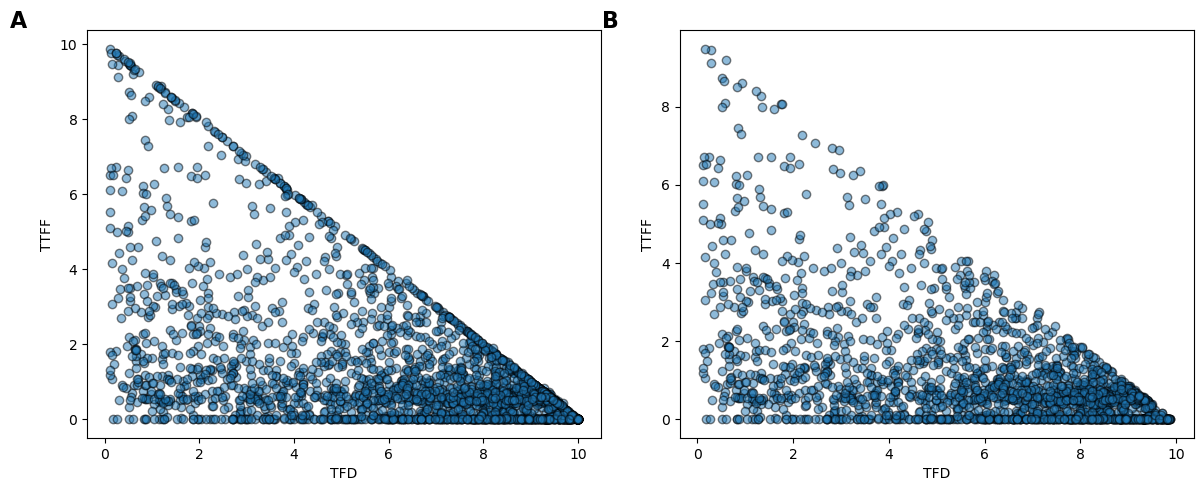

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# File path to the dataset
file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"

# Load the dataset
data = pd.read_csv(file_path)

# Check if required columns exist
if 'TFD' in data.columns and 'TTFF' in data.columns:
    tfd = data['TFD']
    ttff = data['TTFF']

    # 1. Compute correlation for ALL data
    spearman_all, p_all = spearmanr(tfd, ttff)
    print(f"Spearman Correlation (All Data): {spearman_all:.3f} (p-value: {p_all:.5f})")

    # 2. Identify trials where TTFF + TFD < 9.9s (ignoring ceiling cases)
    non_ceiling_data = data[(tfd + ttff) < 9.9]

    # 3. Compute correlation AFTER removing ceiling cases
    spearman_filtered, p_filtered = spearmanr(non_ceiling_data['TFD'], non_ceiling_data['TTFF'])
    print(f"Spearman Correlation (Excluding Ceiling Cases): {spearman_filtered:.3f} (p-value: {p_filtered:.5f})")

    # 4. Plot scatter plots for both cases
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Panel A
    axes[0].scatter(tfd, ttff, alpha=0.5, edgecolors='k')
    axes[0].set_xlabel("TFD")
    axes[0].set_ylabel("TTFF")
    axes[0].set_title("")  # Remove default title
    axes[0].text(-0.15, 1.05, "A", transform=axes[0].transAxes,
                 fontsize=16, fontweight='bold', va='top', ha='left')

    # Panel B
    axes[1].scatter(non_ceiling_data['TFD'], non_ceiling_data['TTFF'], alpha=0.5, edgecolors='k')
    axes[1].set_xlabel("TFD")
    axes[1].set_ylabel("TTFF")
    axes[1].set_title("")  # Remove default title
    axes[1].text(-0.15, 1.05, "B", transform=axes[1].transAxes,
                 fontsize=16, fontweight='bold', va='top', ha='left')

    plt.tight_layout()
    plt.show()

else:
    print("Required columns 'TFD' or 'TTFF' are missing in the dataset.")


Data loaded successfully. Shape: (3316, 17)


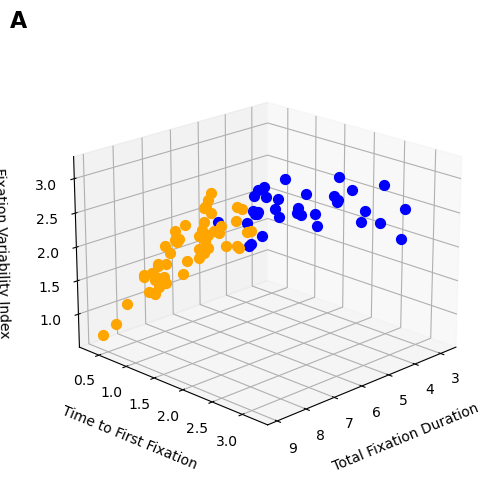

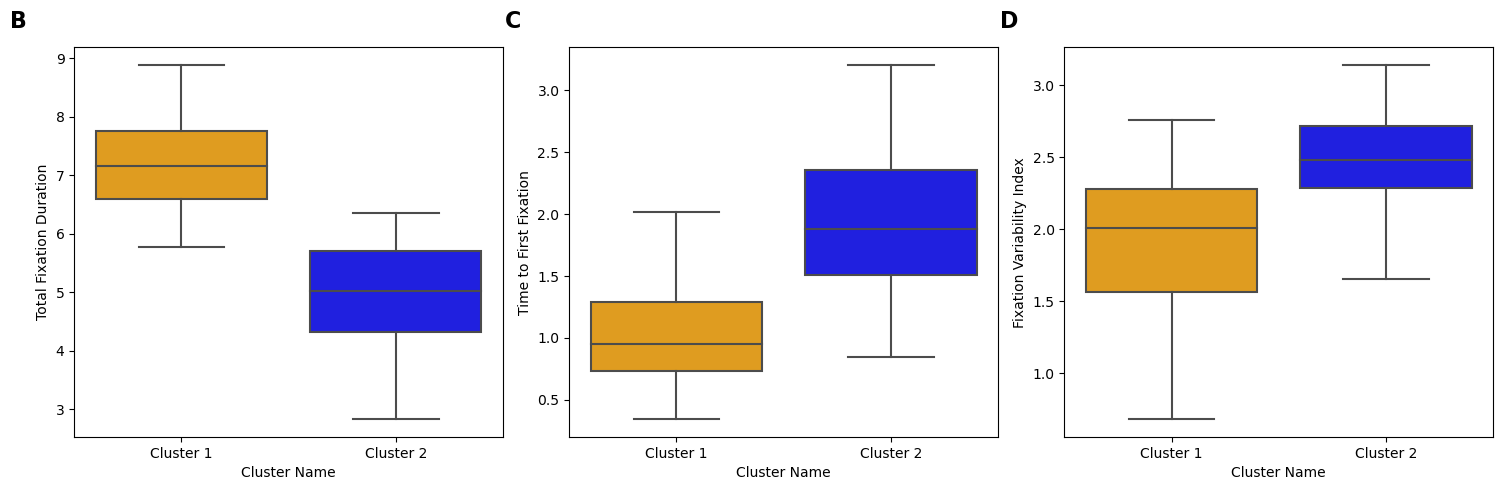

In [79]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# File path to the dataset
file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"

def load_data(file_path):
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully. Shape: {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def prepare_data_no_log(data, total_fixation_duration_col, time_to_first_fixation_col, participant_col):
    try:
        data['Total Fixation Duration'] = data[total_fixation_duration_col]
        data['Time to First Fixation'] = data[time_to_first_fixation_col]

        stds = []
        participants = data[participant_col].unique()
        for participant in participants:
            subset = data[data[participant_col] == participant]
            tfd_std = subset['Total Fixation Duration'].std()
            ttff_std = subset['Time to First Fixation'].std()
            fvi = 0.5 * tfd_std + 0.5 * ttff_std
            stds.append((participant, fvi))

        std_df = pd.DataFrame(stds, columns=[participant_col, 'Fixation Variability Index'])

        agg_df = data.groupby(participant_col)[
            ['Total Fixation Duration', 'Time to First Fixation']
        ].mean().reset_index()

        agg_df = agg_df.merge(std_df, on=participant_col, how='left')
        return agg_df

    except Exception as e:
        print(f"Error preparing data: {e}")
        return None

# Main execution
data = load_data(file_path)
if data is not None:
    prepared_data = prepare_data_no_log(
        data,
        total_fixation_duration_col='TFD',
        time_to_first_fixation_col='TTFF',
        participant_col='Patient'
    )

    if prepared_data is not None:
        cols_for_clustering = ['Total Fixation Duration', 'Time to First Fixation', 'Fixation Variability Index']
        data_clustering = prepared_data.dropna(subset=cols_for_clustering)

        # Fit KMeans
        kmeans = KMeans(n_clusters=2, random_state=42)
        raw_clusters = kmeans.fit_predict(data_clustering[cols_for_clustering])
        data_clustering['Raw_Cluster'] = raw_clusters

        # Determine which cluster is the "engager" (lower TTFF = more engaged)
        ttff_means = data_clustering.groupby('Raw_Cluster')['Time to First Fixation'].mean()
        engager_cluster = ttff_means.idxmin()  # lower TTFF = engager
        cluster_mapping = {engager_cluster: 1, 1 - engager_cluster: 2}
        data_clustering['Cluster'] = data_clustering['Raw_Cluster'].map(cluster_mapping)

        # Map cluster labels for plotting
        data_clustering['Cluster Name'] = data_clustering['Cluster'].map({1: 'Cluster 1', 2: 'Cluster 2'})
        colors = {1: 'orange', 2: 'blue'}

        # Initialize the figure
        fig = plt.figure(figsize=(14, 6))

        # Panel A - 3D Visualization
        ax = fig.add_axes([0.05, 0.15, 0.4, 0.7], projection='3d')
        ax.set_xlabel('Total Fixation Duration', labelpad=10)
        ax.set_ylabel('Time to First Fixation', labelpad=10)
        ax.set_zlabel('Fixation Variability Index', labelpad=10)

        for cluster_label in [1, 2]:
            subset = data_clustering[data_clustering['Cluster'] == cluster_label]
            ax.scatter(
                subset['Total Fixation Duration'],
                subset['Time to First Fixation'],
                subset['Fixation Variability Index'],
                color=colors[cluster_label],
                s=50,
                label=f'Cluster {cluster_label}',
                depthshade=False
            )

        ax.view_init(elev=20, azim=45)
        ax.text2D(-0.1, 1.05, "A", transform=ax.transAxes, fontsize=16, fontweight='bold')
        
        # Panel B - 6 Box Plots (TFD, TTFF, FVI for each cluster)
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        metrics = ['Total Fixation Duration', 'Time to First Fixation', 'Fixation Variability Index']
        titles = ['', '', '']
        
        for i, metric in enumerate(metrics):
            sns.boxplot(x='Cluster Name', y=metric, data=data_clustering, 
                        palette={'Cluster 1': 'orange', 'Cluster 2': 'blue'}, ax=axes[i])
            axes[i].set_title(titles[i])
            axes[i].text(-0.15, 1.05, chr(66 + i), transform=axes[i].transAxes, fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        plt.show()


In [76]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import chi2_contingency, mannwhitneyu
import matplotlib.pyplot as plt

# File paths
clinical_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\clinical data.xlsx"
clustering_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"

# Load datasets
clinical_data = pd.read_excel(clinical_file_path)
clustering_data = pd.read_csv(clustering_file_path)

# Format `Patient` IDs in clustering data to match `AP###` format
clustering_data['Patient'] = clustering_data['Patient'].apply(lambda x: f"AP{int(x):03}")

# Prepare the data with General Standard Deviation (General Std) for clustering
def prepare_general_std_data(data, tfd_col, ttff_col, participant_col):
    """
    Prepares data for clustering using log-transformed TFD, TTFF, and a combined standard deviation (General Std).
    """
    # Log-transform TFD and TTFF
    data['Log_TFD'] = np.log(data[tfd_col] + 1)
    data['Log_TTFF'] = np.log(data[ttff_col] + 1)

    # Calculate standard deviations for Log_TFD and Log_TTFF
    stds = []
    participants = data[participant_col].unique()
    for participant in participants:
        subset = data[data[participant_col] == participant]
        tfd_std = subset['Log_TFD'].std()
        ttff_std = subset['Log_TTFF'].std()

        # Combine into General Std (equal weights)
        general_std = 0.5 * tfd_std + 0.5 * ttff_std
        stds.append((participant, general_std))

    std_data = pd.DataFrame(stds, columns=[participant_col, 'General_Std'])

    # Aggregate log-transformed TFD and TTFF
    aggregated_data = data.groupby(participant_col)[['Log_TFD', 'Log_TTFF']].mean().reset_index()

    # Merge General Std into aggregated data
    aggregated_data = aggregated_data.merge(std_data, on=participant_col)

    return aggregated_data

# Generate the General Std clustering data
data_prepared = prepare_general_std_data(clustering_data, tfd_col='TFD', ttff_col='TTFF', participant_col='Patient')

# Drop rows with NaN values in TFD and TTFF only for clustering
data_prepared = data_prepared.dropna(subset=['Log_TFD', 'Log_TTFF'])

# Scale the data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_prepared[['Log_TFD', 'Log_TTFF', 'General_Std']]), 
                           columns=['Log_TFD', 'Log_TTFF', 'General_Std'], 
                           index=data_prepared['Patient'])

# Perform K-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
data_prepared['Cluster'] = kmeans.fit_predict(data_scaled)

# Map cluster labels back to the original data
clustering_data['Cluster'] = clustering_data['Patient'].map(data_prepared.set_index('Patient')['Cluster'])

# Merge Cluster labels with clinical data
clinical_data['patient'] = clinical_data['patient'].str.upper()  # Ensure uppercase consistency
merged_data = pd.merge(
    clinical_data.rename(columns={'patient': 'Patient'}),
    data_prepared[['Patient', 'Cluster']],
    on='Patient',
    how='inner'
)

# Handle missing values for critical columns
critical_columns = ['LARS', 'MOCA_1', 'gds_total']
for col in critical_columns:
    merged_data[col] = merged_data[col].fillna(merged_data[col].median())

# Define clinically significant thresholds with updated cutoffs
merged_data['LARS_Apathy'] = merged_data['LARS'] > -8
merged_data['MOCA_Normal'] = merged_data['MOCA_1'] >= 25

# Calculate frequencies and proportions for each group and variable
frequency_table = merged_data.groupby('Cluster')[['LARS_Apathy', 'MOCA_Normal']].sum()
total_counts = merged_data['Cluster'].value_counts()
frequency_table['Total'] = total_counts
frequency_table['LARS_Apathy_Proportion'] = frequency_table['LARS_Apathy'] / frequency_table['Total']
frequency_table['MOCA_Normal_Proportion'] = frequency_table['MOCA_Normal'] / frequency_table['Total']

# Chi-square tests for LARS_Apathy and MOCA_Normal
chi_square_results = []
for col in ['LARS_Apathy', 'MOCA_Normal']:
    contingency_table = pd.crosstab(merged_data['Cluster'], merged_data[col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results.append({
        "Variable": col,
        "Chi2": chi2,
        "P-Value": p
    })

# Convert chi-square results to DataFrame
chi_square_results_df = pd.DataFrame(chi_square_results)

# Group data by cluster
cluster_0 = merged_data[merged_data['Cluster'] == 0]
cluster_1 = merged_data[merged_data['Cluster'] == 1]

# Add counts (n) for each cluster
cluster_0_n = len(cluster_0)
cluster_1_n = len(cluster_1)

# Perform Mann-Whitney U test safely
def safe_mannwhitneyu(data1, data2):
    if len(data1) > 1 and len(data2) > 1:
        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
    else:
        stat, p = None, None
    return stat, p

# Mann-Whitney U test for LARS, 
# _1, and GDS Total
results = []
for col in critical_columns:
    stat, p = safe_mannwhitneyu(cluster_0[col].dropna(), cluster_1[col].dropna())
    results.append({
        "Variable": col,
        "Cluster 0 Mean": cluster_0[col].mean(),
        "Cluster 1 Mean": cluster_1[col].mean(),
        "Cluster 0 n": cluster_0_n,
        "Cluster 1 n": cluster_1_n,
        "U Statistic": stat,
        "P-Value": p
    })

# Create a results table
results_table = pd.DataFrame(results)

# Display results tables
print("Chi-Square Results:")
print(chi_square_results_df)
print("\nMann-Whitney U Test Results:")
print(results_table)
print("\nFrequency Table:")
print(frequency_table)



import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

print("\n--- Logistic Regression: Cluster ~ LARS ---")
df_logit1 = merged_data[['Cluster', 'LARS']].dropna()
if df_logit1['Cluster'].nunique() == 2:
    model1 = smf.logit('Cluster ~ LARS', data=df_logit1).fit(disp=False)
    coef = model1.params['LARS']
    se = model1.bse['LARS']
    or_val = np.exp(coef)
    ci_lower = np.exp(coef - 1.96 * se)
    ci_upper = np.exp(coef + 1.96 * se)
    pval = model1.pvalues['LARS']
    print(f"LARS: OR = {or_val:.2f}, 95% CI [{ci_lower:.2f}, {ci_upper:.2f}], p = {pval:.4f}")
else:
    print("Insufficient variation in Cluster variable.")

print("\n--- Logistic Regression: Cluster ~ LARS + MOCA_1 ---")
df_logit2 = merged_data[['Cluster', 'LARS', 'MOCA_1']].dropna()
if df_logit2['Cluster'].nunique() == 2:
    model2 = smf.logit('Cluster ~ LARS + MOCA_1', data=df_logit2).fit(disp=False)
    for var in ['LARS', 'MOCA_1']:
        coef = model2.params[var]
        se = model2.bse[var]
        or_val = np.exp(coef)
        ci_lower = np.exp(coef - 1.96 * se)
        ci_upper = np.exp(coef + 1.96 * se)
        pval = model2.pvalues[var]
        print(f"{var}: OR = {or_val:.2f}, 95% CI [{ci_lower:.2f}, {ci_upper:.2f}], p = {pval:.4f}")
else:
    print("Insufficient variation in Cluster variable.")

df['LARS_Apathy'] = df['LARS'] 
model_cat = smf.logit('Cluster ~ LARS_Apathy', data=df).fit()
print(model_cat.summary())



Chi-Square Results:
      Variable       Chi2   P-Value
0  LARS_Apathy   1.501334  0.220466
1  MOCA_Normal  10.804837  0.001012

Mann-Whitney U Test Results:
    Variable  Cluster 0 Mean  Cluster 1 Mean  Cluster 0 n  Cluster 1 n  \
0       LARS      -10.833333       -9.135135           48           37   
1     MOCA_1       24.020833       18.270270           48           37   
2  gds_total        2.312500        3.000000           48           37   

   U Statistic   P-Value  
0        606.0  0.012207  
1       1409.5  0.000004  
2        691.5  0.076543  

Frequency Table:
         LARS_Apathy  MOCA_Normal  Total  LARS_Apathy_Proportion  \
Cluster                                                            
0                 10           24     48                0.208333   
1                 13            5     37                0.351351   

         MOCA_Normal_Proportion  
Cluster                          
0                      0.500000  
1                      0.135135  

--- Logis

KeyError: 'LARS'

In [77]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf

# ========= נתיבים =========
clinical_file_path   = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\clinical data.xlsx"
clustering_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"

# ========= טעינה =========
clinical = pd.read_excel(clinical_file_path)
vr = pd.read_csv(clustering_file_path)

# ========= פורמט מזהים =========
vr['Patient'] = vr['Patient'].apply(lambda x: f"AP{int(x):03}")
clinical['patient'] = clinical['patient'].str.upper()
clinical = clinical.rename(columns={'patient': 'Patient'})

# ========= פונקציה להכנת נתוני קלאסטרינג =========
def prepare_general_std_data(data, tfd_col='TFD', ttff_col='TTFF', participant_col='Patient'):
    d = data.copy()
    d['Log_TFD']  = np.log(d[tfd_col].astype(float) + 1)
    d['Log_TTFF'] = np.log(d[ttff_col].astype(float) + 1)

    rows = []
    for pid, g in d.groupby(participant_col):
        tfd_std  = g['Log_TFD'].std()
        ttff_std = g['Log_TTFF'].std()
        general_std = 0.5 * tfd_std + 0.5 * ttff_std
        rows.append((pid, general_std))
    std_df = pd.DataFrame(rows, columns=[participant_col, 'General_Std'])

    agg = d.groupby(participant_col)[['Log_TFD', 'Log_TTFF']].mean().reset_index()
    agg = agg.merge(std_df, on=participant_col, how='left')
    return agg

# ========= הכנת נתוני קלאסטרינג =========
prep = prepare_general_std_data(vr, 'TFD', 'TTFF', 'Patient').dropna(subset=['Log_TFD','Log_TTFF','General_Std'])

# סקלינג
scaler = MinMaxScaler()
X = scaler.fit_transform(prep[['Log_TFD','Log_TTFF','General_Std']])

# KMeans k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
prep['Cluster'] = kmeans.fit_predict(X).astype(int)

# ========= מיזוג לקליניקה (ברמת נבדק יחיד) =========
# אם יש כפילויות באקסל – ניקח את הרשומה הראשונה לכל Patient
clin_keep = ['Patient', 'LARS', 'MOCA_1', 'crf_tes_age']
for c in clin_keep:
    if c not in clinical.columns:
        raise ValueError(f"עמודה חסרה בקובץ הקליני: {c}")

clinical_sub = (clinical[clin_keep]
                .drop_duplicates(subset=['Patient'])
                .copy())

df = prep[['Patient','Cluster']].merge(clinical_sub, on='Patient', how='inner')

# המרות מספריות ובקרת NA
for c in ['LARS','MOCA_1','crf_tes_age']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# לא עושים אימפיוט — מודל לפי NA-drop פר-מודל
df = df[['Patient','Cluster','LARS','MOCA_1','crf_tes_age']].drop_duplicates()

# למניעת בלבול — נשמור Alias ברור לגיל
df = df.rename(columns={'crf_tes_age': 'Age'})

# ========= פונקציה לפיט לוגיסטי והחזרת טבלה מסודרת =========
def fit_logit_and_tidy(formula, data, model_name):
    # מסנן NA רק למשתנים שבמודל
    vars_in_formula = [v.strip() for v in formula.replace('~', '+').split('+')]
    vars_in_formula = [v for v in vars_in_formula if v and v != 'Cluster']
    dat = data[['Cluster'] + vars_in_formula].dropna().copy()

    out_rows = []
    if dat['Cluster'].nunique() != 2 or len(dat) < 8:
        return pd.DataFrame([{
            'Model': model_name,
            'Predictor': '(model not fit)',
            'N': len(dat),
            'Beta': np.nan, 'SE': np.nan, 'z': np.nan, 'p': np.nan,
            'OR': np.nan, 'CI95_low': np.nan, 'CI95_high': np.nan,
            'McFadden_R2': np.nan, 'AIC': np.nan, 'BIC': np.nan
        }])

    try:
        m = smf.logit(formula, data=dat).fit(disp=False)
    except Exception as e:
        return pd.DataFrame([{
            'Model': model_name,
            'Predictor': f'(failed: {e})',
            'N': len(dat),
            'Beta': np.nan, 'SE': np.nan, 'z': np.nan, 'p': np.nan,
            'OR': np.nan, 'CI95_low': np.nan, 'CI95_high': np.nan,
            'McFadden_R2': np.nan, 'AIC': np.nan, 'BIC': np.nan
        }])

    # סטטיסטיקות כלליות למודל
    N = int(m.nobs)
    try:
        r2_mcfadden = 1 - (m.llf / m.llnull)
    except Exception:
        r2_mcfadden = np.nan

    # שורה לכל פרדיקטור (למעט Intercept)
    for pred in [p for p in m.params.index if p != 'Intercept']:
        beta = m.params[pred]
        se   = m.bse[pred]
        z    = beta / se if se and se==se else np.nan
        pval = m.pvalues[pred]
        OR   = np.exp(beta)
        ci_l = np.exp(beta - 1.96*se)
        ci_h = np.exp(beta + 1.96*se)

        out_rows.append({
            'Model': model_name,
            'Predictor': pred,
            'N': N,
            'Beta': beta,
            'SE': se,
            'z': z,
            'p': pval,
            'OR': OR,
            'CI95_low': ci_l,
            'CI95_high': ci_h,
            'McFadden_R2': r2_mcfadden,
            'AIC': m.aic,
            'BIC': m.bic
        })

    return pd.DataFrame(out_rows)

# ========= הגדרת 6 המודלים =========
models = [
    ("(1) Cluster ~ LARS",                 "Cluster ~ LARS"),
    ("(2) Cluster ~ LARS + MOCA_1",        "Cluster ~ LARS + MOCA_1"),
    ("(3) Cluster ~ MOCA_1",               "Cluster ~ MOCA_1"),
    ("(4) Cluster ~ MOCA_1 + Age",         "Cluster ~ MOCA_1 + Age"),
    ("(5) Cluster ~ LARS + Age",           "Cluster ~ LARS + Age"),
    ("(6) Cluster ~ LARS + MOCA_1 + Age",  "Cluster ~ LARS + MOCA_1 + Age"),
]

# ========= הרצה וריכוז לתבלה אחת =========
tables = []
for name, formula in models:
    tables.append(fit_logit_and_tidy(formula, df, name))
results_table = pd.concat(tables, ignore_index=True)

# ========= הדפסה מסודרת =========
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: f"{x:.4f}")

print("\n=== Logistic Regression Summary (OR, 95% CI, p) ===")
print(results_table[['Model','Predictor','N','OR','CI95_low','CI95_high','p','McFadden_R2','AIC','BIC']])

# אופציונלי: לשמור לקובץ
# results_table.to_csv(r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\logit_models_summary.csv", index=False)

# === הדפסת Z-values בצורה פשוטה ===
print("\n=== Z-values by Model ===")
for name, formula in models:
    vars_in_formula = [v.strip() for v in formula.replace('~', '+').split('+')]
    vars_in_formula = [v for v in vars_in_formula if v and v != 'Cluster']
    dat = df[['Cluster'] + vars_in_formula].dropna().copy()
    if dat['Cluster'].nunique() != 2 or len(dat) < 8:
        print(f"{name}: (model not fit)")
        continue
    try:
        m = smf.logit(formula, data=dat).fit(disp=False)
    except Exception as e:
        print(f"{name}: (failed: {e})")
        continue
    for pred in [p for p in m.params.index if p != 'Intercept']:
        z_val = m.tvalues[pred] if hasattr(m, "tvalues") else m.params[pred] / m.bse[pred]
        print(f"{name} – {pred}: Z = {z_val:.3f}")



=== Logistic Regression Summary (OR, 95% CI, p) ===
                                Model Predictor   N     OR  CI95_low  \
0                  (1) Cluster ~ LARS      LARS  85 1.1220    0.9989   
1         (2) Cluster ~ LARS + MOCA_1      LARS  85 1.0580    0.9307   
2         (2) Cluster ~ LARS + MOCA_1    MOCA_1  85 0.7958    0.7117   
3                (3) Cluster ~ MOCA_1    MOCA_1  85 0.7887    0.7061   
4          (4) Cluster ~ MOCA_1 + Age    MOCA_1  85 0.7967    0.7117   
5          (4) Cluster ~ MOCA_1 + Age       Age  85 1.0525    0.9606   
6            (5) Cluster ~ LARS + Age      LARS  85 1.1160    0.9899   
7            (5) Cluster ~ LARS + Age       Age  85 1.0905    1.0068   
8   (6) Cluster ~ LARS + MOCA_1 + Age      LARS  85 1.0602    0.9323   
9   (6) Cluster ~ LARS + MOCA_1 + Age    MOCA_1  85 0.8039    0.7175   
10  (6) Cluster ~ LARS + MOCA_1 + Age       Age  85 1.0538    0.9617   

    CI95_high      p  McFadden_R2      AIC      BIC  
0      1.2602 0.0522       0

In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.stats import mannwhitneyu

# File paths
lars_features_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\LARS.csv"
clustering_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"

# Load LARS features and clustering data
lars_data = pd.read_csv(lars_features_file_path)
clustering_data = pd.read_csv(clustering_file_path)

# Format Patient IDs to match AP### format
clustering_data['Patient'] = clustering_data['Patient'].apply(lambda x: f"AP{int(x):03}")
lars_data['crf_record_id'] = lars_data['crf_record_id'].str.upper()

# Prepare the data with General Standard Deviation (General Std) for clustering
def prepare_general_std_data(data, tfd_col, ttff_col, participant_col):
    """
    Prepares data for clustering using log-transformed TFD, TTFF, and a combined standard deviation (General Std).
    """
    # Log-transform TFD and TTFF
    data['Log_TFD'] = np.log(data[tfd_col] + 1)
    data['Log_TTFF'] = np.log(data[ttff_col] + 1)

    # Calculate standard deviations for Log_TFD and Log_TTFF
    stds = []
    participants = data[participant_col].unique()
    for participant in participants:
        subset = data[data[participant_col] == participant]
        tfd_std = subset['Log_TFD'].std()
        ttff_std = subset['Log_TTFF'].std()

        # Combine into General Std (equal weights)
        general_std = 0.5 * tfd_std + 0.5 * ttff_std
        stds.append((participant, general_std))

    std_data = pd.DataFrame(stds, columns=[participant_col, 'General_Std'])

    # Aggregate log-transformed TFD and TTFF
    aggregated_data = data.groupby(participant_col)[['Log_TFD', 'Log_TTFF']].mean().reset_index()

    # Merge General Std into aggregated data
    aggregated_data = aggregated_data.merge(std_data, on=participant_col)

    return aggregated_data

# Generate the General Std clustering data
data_prepared = prepare_general_std_data(clustering_data, tfd_col='TFD', ttff_col='TTFF', participant_col='Patient')

# Drop rows with NaN values in TFD and TTFF only for clustering
data_prepared = data_prepared.dropna(subset=['Log_TFD', 'Log_TTFF'])

# Scale the data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_prepared[['Log_TFD', 'Log_TTFF', 'General_Std']]), 
                           columns=['Log_TFD', 'Log_TTFF', 'General_Std'], 
                           index=data_prepared['Patient'])

# Perform K-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
data_prepared['Cluster'] = kmeans.fit_predict(data_scaled)

# Add cluster labels back to the original data
clustering_data['Cluster'] = clustering_data['Patient'].map(data_prepared.set_index('Patient')['Cluster'])

# Merge clustering data with LARS data
merged_data = pd.merge(
    data_prepared[['Patient', 'Cluster']],
    lars_data.rename(columns={'crf_record_id': 'Patient'}),
    on='Patient',
    how='inner'
)

# Define LARS features and their aggregation domains
lars_features = [
    'lars_ans_tm', 'lars_act', 'lars_ans_tm_2', 'lars_cnt_act', 'lars_ini', 
    'lars_indi', 'lars_ex', 'lars_nw', 'lars_mot', 'lars_em_rea', 'lars_lgh'
]
lars_domains = {
    'Cognitive': ['lars_ans_tm', 'lars_ans_tm_2', 'lars_indi'],
    'Behavioral': ['lars_act', 'lars_cnt_act', 'lars_ex'],
    'Emotional': ['lars_mot', 'lars_em_rea', 'lars_nw', 'lars_lgh']
}

# Aggregate LARS domains
def aggregate_lars_domains(data, lars_domains):
    domain_aggregates = {}
    for domain, features in lars_domains.items():
        if all(feature in data.columns for feature in features):
            domain_aggregates[domain] = data[features].mean(axis=1)
        else:
            print(f"Missing features for domain {domain}: {[f for f in features if f not in data.columns]}")
    return pd.DataFrame(domain_aggregates)

lars_aggregated = aggregate_lars_domains(merged_data, lars_domains)

# Merge aggregated LARS domains with cluster information
lars_aggregated['Cluster'] = merged_data['Cluster']

# Perform Mann-Whitney U test for each LARS domain
results = []
for domain in lars_aggregated.columns[:-1]:  # Exclude 'Cluster'
    cluster_0 = lars_aggregated[lars_aggregated['Cluster'] == 0][domain].dropna()
    cluster_1 = lars_aggregated[lars_aggregated['Cluster'] == 1][domain].dropna()
    if len(cluster_0) > 0 and len(cluster_1) > 0:
        stat, p = mannwhitneyu(cluster_0, cluster_1, alternative='two-sided')
        results.append({
            "Domain": domain,
            "Cluster 0 Mean": cluster_0.mean(),
            "Cluster 1 Mean": cluster_1.mean(),
            "Cluster 0 n": len(cluster_0),
            "Cluster 1 n": len(cluster_1),
            "U Statistic": stat,
            "P-Value": p
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display cluster sizes
cluster_counts = data_prepared['Cluster'].value_counts()
print("Cluster sizes:")
print(cluster_counts)

# Display results
print("\nLARS Domain Comparison Results:")
print(results_df)


Cluster sizes:
Cluster
0    48
1    37
Name: count, dtype: int64

LARS Domain Comparison Results:
       Domain  Cluster 0 Mean  Cluster 1 Mean  Cluster 0 n  Cluster 1 n  \
0   Cognitive         -1.4028         -1.2342           48           37   
1  Behavioral         -0.8403         -0.6216           48           37   
2   Emotional         -0.6927         -0.6216           48           37   

   U Statistic  P-Value  
0     714.0000   0.0816  
1     664.0000   0.0425  
2     855.0000   0.7622  


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import chi2_contingency, mannwhitneyu
import matplotlib.pyplot as plt

# File paths
clinical_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\clinical data.xlsx"
clustering_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"

# Load datasets
clinical_data = pd.read_excel(clinical_file_path)
clustering_data = pd.read_csv(clustering_file_path)

# Format `Patient` IDs in clustering data to match `AP###` format
clustering_data['Patient'] = clustering_data['Patient'].apply(lambda x: f"AP{int(x):03}")

# Prepare the data with General Standard Deviation (General Std) for clustering
def prepare_general_std_data(data, tfd_col, ttff_col, participant_col):
    """
    Prepares data for clustering using log-transformed TFD, TTFF, and a combined standard deviation (General Std).
    """
    # Log-transform TFD and TTFF
    data['Log_TFD'] = np.log(data[tfd_col] + 1)
    data['Log_TTFF'] = np.log(data[ttff_col] + 1)

    # Calculate standard deviations for Log_TFD and Log_TTFF
    stds = []
    participants = data[participant_col].unique()
    for participant in participants:
        subset = data[data[participant_col] == participant]
        tfd_std = subset['Log_TFD'].std()
        ttff_std = subset['Log_TTFF'].std()

        # Combine into General Std (equal weights)
        general_std = 0.5 * tfd_std + 0.5 * ttff_std
        stds.append((participant, general_std))

    std_data = pd.DataFrame(stds, columns=[participant_col, 'General_Std'])

    # Aggregate log-transformed TFD and TTFF
    aggregated_data = data.groupby(participant_col)[['Log_TFD', 'Log_TTFF']].mean().reset_index()

    # Merge General Std into aggregated data
    aggregated_data = aggregated_data.merge(std_data, on=participant_col)

    return aggregated_data

# Generate the General Std clustering data
data_prepared = prepare_general_std_data(clustering_data, tfd_col='TFD', ttff_col='TTFF', participant_col='Patient')

# Drop rows with NaN values in TFD and TTFF only for clustering
data_prepared = data_prepared.dropna(subset=['Log_TFD', 'Log_TTFF'])

# Scale the data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_prepared[['Log_TFD', 'Log_TTFF', 'General_Std']]), 
                           columns=['Log_TFD', 'Log_TTFF', 'General_Std'], 
                           index=data_prepared['Patient'])

# Perform K-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
data_prepared['Cluster'] = kmeans.fit_predict(data_scaled)

# Map cluster labels back to the original data
clustering_data['Cluster'] = clustering_data['Patient'].map(data_prepared.set_index('Patient')['Cluster'])

# Merge Cluster labels with clinical data
clinical_data['patient'] = clinical_data['patient'].str.upper()  # Ensure uppercase consistency
merged_data = pd.merge(
    clinical_data.rename(columns={'patient': 'Patient'}),
    data_prepared[['Patient', 'Cluster']],
    on='Patient',
    how='inner'
)

# Handle missing values for critical columns
critical_columns = ['LARS', 'MOCA_1', 'gds_total']
for col in critical_columns:
    merged_data[col] = merged_data[col].fillna(merged_data[col].median())

# Define clinically significant thresholds with updated cutoffs
merged_data['LARS_Apathy'] = merged_data['LARS'] >= -8
merged_data['MOCA_Normal'] = merged_data['MOCA_1'] >= 25

# Calculate frequencies and proportions for each group and variable
frequency_table = merged_data.groupby('Cluster')[['LARS_Apathy', 'MOCA_Normal']].sum()
total_counts = merged_data['Cluster'].value_counts()
frequency_table['Total'] = total_counts
frequency_table['LARS_Apathy_Proportion'] = frequency_table['LARS_Apathy'] / frequency_table['Total']
frequency_table['MOCA_Normal_Proportion'] = frequency_table['MOCA_Normal'] / frequency_table['Total']

# Chi-square tests for LARS_Apathy and MOCA_Normal
chi_square_results = []
for col in ['LARS_Apathy', 'MOCA_Normal']:
    contingency_table = pd.crosstab(merged_data['Cluster'], merged_data[col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results.append({
        "Variable": col,
        "Chi2": chi2,
        "P-Value": p
    })

# Convert chi-square results to DataFrame
chi_square_results_df = pd.DataFrame(chi_square_results)

# Group data by cluster
cluster_0 = merged_data[merged_data['Cluster'] == 0]
cluster_1 = merged_data[merged_data['Cluster'] == 1]

# Add counts (n) for each cluster
cluster_0_n = len(cluster_0)
cluster_1_n = len(cluster_1)

# Perform Mann-Whitney U test safely
def safe_mannwhitneyu(data1, data2):
    if len(data1) > 1 and len(data2) > 1:
        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
    else:
        stat, p = None, None
    return stat, p

# Mann-Whitney U test for LARS, MOCA_1, and GDS Total
results = []
for col in critical_columns:
    stat, p = safe_mannwhitneyu(cluster_0[col].dropna(), cluster_1[col].dropna())
    results.append({
        "Variable": col,
        "Cluster 0 Mean": cluster_0[col].mean(),
        "Cluster 1 Mean": cluster_1[col].mean(),
        "Cluster 0 n": cluster_0_n,
        "Cluster 1 n": cluster_1_n,
        "U Statistic": stat,
        "P-Value": p
    })

# Create a results table
results_table = pd.DataFrame(results)

# Display results tables
print("Chi-Square Results:")
print(chi_square_results_df)
print("\nMann-Whitney U Test Results:")
print(results_table)
print("\nFrequency Table:")
print(frequency_table)


Chi-Square Results:
      Variable       Chi2   P-Value
0  LARS_Apathy   4.028015  0.044751
1  MOCA_Normal  10.804837  0.001012

Mann-Whitney U Test Results:
    Variable  Cluster 0 Mean  Cluster 1 Mean  Cluster 0 n  Cluster 1 n  \
0       LARS      -10.833333       -9.135135           48           37   
1     MOCA_1       24.020833       18.270270           48           37   
2  gds_total        2.312500        3.000000           48           37   

   U Statistic   P-Value  
0        606.0  0.012207  
1       1409.5  0.000004  
2        691.5  0.076543  

Frequency Table:
         LARS_Apathy  MOCA_Normal  Total  LARS_Apathy_Proportion  \
Cluster                                                            
0                 11           24     48                0.229167   
1                 17            5     37                0.459459   

         MOCA_Normal_Proportion  
Cluster                          
0                      0.500000  
1                      0.135135  


C:\Users\LAB-Mobile\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# === נתיבים ===
vr_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"
lars_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\LARS.csv"
moca_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\MOCA.xlsx"

# === טעינת קבצים ===
vr_df = pd.read_csv(vr_path)
lars_df = pd.read_csv(lars_path)
moca_df = pd.read_excel(moca_path)

# === עיבוד מזהים ===
vr_df['Patient'] = vr_df['Patient'].apply(lambda x: f"AP{int(x):03}")
lars_df['crf_record_id'] = lars_df['crf_record_id'].str.upper()
moca_df['crf_record_id'] = moca_df['crf_record_id'].str.upper()

# === חישוב log-TFD, log-TTFF לכל שורה ===
vr_df['Log_TFD'] = np.log(vr_df['TFD'] + 1)
vr_df['Log_TTFF'] = np.log(vr_df['TTFF'] + 1)

# === חישוב סטיית תקן כללית לנבדק ===
general_std = (
    vr_df.groupby('Patient')[['Log_TFD', 'Log_TTFF']]
    .std().mean(axis=1).rename("General_Std")
)
agg_means = (
    vr_df.groupby('Patient')[['Log_TFD', 'Log_TTFF']]
    .mean()
)
gaze_df = pd.concat([agg_means, general_std], axis=1).reset_index()

# === קלאסטרינג רק לנבדקים עם כל מדדי הגז
gaze_df_clean = gaze_df.dropna(subset=['Log_TFD', 'Log_TTFF', 'General_Std'])
X = gaze_df_clean[['Log_TFD', 'Log_TTFF', 'General_Std']]
X_scaled = MinMaxScaler().fit_transform(X)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
gaze_df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# === מיזוג נתונים
merged_data = (
    gaze_df_clean
    .merge(lars_df.rename(columns={'crf_record_id': 'Patient'}), on='Patient', how='inner')
    .merge(moca_df.rename(columns={'crf_record_id': 'Patient'}), on='Patient', how='inner')
)

# === חישוב דומיינים של LARS
lars_domains = {
    'LARS_Cognitive': ['lars_ans_tm', 'lars_ans_tm_2', 'lars_indi'],
    'LARS_Behavioral': ['lars_act', 'lars_cnt_act', 'lars_ex'],
    'LARS_Emotional': ['lars_mot', 'lars_em_rea', 'lars_nw', 'lars_lgh']
}
for domain, cols in lars_domains.items():
    merged_data[domain] = merged_data[cols].mean(axis=1)

# === חישוב דומיינים של MOCA לפי Goldstein et al. (2018)
moca_vars = {
    'MOCA_Executive': merged_data[['moca01_tmt',  'moca21_fluency', 'moca_abstract_score']].mean(axis=1),
    'MOCA_Visuospatial': merged_data[['moca_execut_score' ]].mean(axis=1),
    'MOCA_Language': merged_data[['moca_naming_score', 'moca_repeat_score']].mean(axis=1),
    'MOCA_Attention': merged_data[['moca_digitlist_score', 'moca_gonogo_score', 'moca_serial7_score']].mean(axis=1),
    'MOCA_Orientation': merged_data['moca_orient_score'],
    'MOCA_Recall': merged_data['moca_recall_score']
}
for domain, series in moca_vars.items():
    merged_data[domain] = pd.to_numeric(series, errors='coerce')
merged_data['MOCA_Total'] = merged_data[list(moca_vars.keys())].mean(axis=1)

# === LARS Total
merged_data['LARS_Total'] = merged_data[list(set(sum(lars_domains.values(), [])))].mean(axis=1)

# === Logistic: Cluster ~ LARS domains
print("\n--- Logistic Regressions: Cluster ~ Each LARS domain ---")
for domain in lars_domains.keys():
    df = merged_data[['Cluster', domain]].dropna()
    model = smf.logit(f"Cluster ~ {domain}", data=df).fit(disp=False)
    print(f"{domain}: p = {model.pvalues.iloc[1]:.4f}, OR = {np.exp(model.params.iloc[1]):.2f}")

# === Interaction: Cluster ~ LARS × MOCA domains
print("\n--- Interaction Models: Cluster ~ LARS × MoCA domains ---")
for lars_dom in lars_domains:
    for moca_dom in moca_vars:
        interaction_term = f"{lars_dom}:{moca_dom}"
        cols = ['Cluster', lars_dom, moca_dom]
        df = merged_data[cols].dropna()
        if len(df) < 10:
            continue
        try:
            model = smf.logit(f"Cluster ~ {lars_dom} * {moca_dom}", data=df).fit(disp=False)
            pval = model.pvalues.get(interaction_term, np.nan)
            print(f"{lars_dom} × {moca_dom}: p = {pval:.4f}")
        except Exception as e:
            print(f"{lars_dom} × {moca_dom}: Error - {e}")

# === Interaction: Cluster ~ LARS_Total × MOCA Domains
print("\n--- Interaction Models: LARS_Total × MOCA Domains ---")
for moca_dom in moca_vars:
    cols = ['Cluster', 'LARS_Total', moca_dom]
    df = merged_data[cols].dropna()
    if len(df) < 10:
        continue
    try:
        model = smf.logit(f"Cluster ~ LARS_Total * {moca_dom}", data=df).fit(disp=False)
        pval = model.pvalues.get(f'LARS_Total:{moca_dom}', np.nan)
        print(f"LARS_Total × {moca_dom}: p = {pval:.4f}")
    except Exception as e:
        print(f"LARS_Total × {moca_dom}: Error - {e}")

# === Interaction: Cluster ~ MOCA_Total × LARS domains
print("\n--- Interaction Models: MOCA_Total × LARS Domains ---")
for lars_dom in lars_domains:
    df = merged_data[['Cluster', 'MOCA_Total', lars_dom]].dropna()
    if len(df) < 10:
        continue
    try:
        model = smf.logit(f"Cluster ~ MOCA_Total * {lars_dom}", data=df).fit(disp=False)
        pval = model.pvalues.get(f'MOCA_Total:{lars_dom}', np.nan)
        print(f"MOCA_Total × {lars_dom}: p = {pval:.4f}")
    except Exception as e:
        print(f"MOCA_Total × {lars_dom}: Error - {e}")

# === מתאמי ספירמן בין LARS לגז
behavior_vars = ['Log_TFD', 'Log_TTFF', 'General_Std']
print("\n--- Spearman Correlations: LARS Domains with Gaze Metrics ---")
for domain in lars_domains:
    for behavior in behavior_vars:
        df = merged_data[[domain, behavior]].dropna()
        if len(df) < 5:
            continue
        r, p = spearmanr(df[domain], df[behavior])
        print(f"{domain} vs {behavior}: r = {r:.2f}, p = {p:.4f}")

# === מתאמי ספירמן בין MOCA לגז
print("\n--- Spearman Correlations: MOCA Domains with Gaze Metrics ---")
for domain in moca_vars:
    for behavior in behavior_vars:
        df = merged_data[[domain, behavior]].dropna()
        if len(df) < 5:
            continue
        r, p = spearmanr(df[domain], df[behavior])
        print(f"{domain} vs {behavior}: r = {r:.2f}, p = {p:.4f}")

# === טבלת מתאמים בין MOCA ל-LARS
r_matrix = pd.DataFrame(index=moca_vars.keys(), columns=lars_domains.keys(), dtype=float)
p_matrix = pd.DataFrame(index=moca_vars.keys(), columns=lars_domains.keys(), dtype=float)
print("\n--- Spearman Correlations between MoCA and LARS domains ---")
for moca_dom in moca_vars:
    for lars_dom in lars_domains:
        df = merged_data[[moca_dom, lars_dom]].dropna()
        if len(df) >= 5:
            r, p = spearmanr(df[moca_dom], df[lars_dom])
            r_matrix.loc[moca_dom, lars_dom] = round(r, 2)
            p_matrix.loc[moca_dom, lars_dom] = p
            sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
            print(f"{moca_dom} × {lars_dom}: r = {r:.2f}, p = {p:.4f} {sig}")

# === מתאם כולל
print("\n--- MoCA_Total × LARS Domains ---")
for lars_dom in lars_domains:
    df = merged_data[['MOCA_Total', lars_dom]].dropna()
    if len(df) >= 5:
        r, p = spearmanr(df['MOCA_Total'], df[lars_dom])
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        print(f"MOCA_Total × {lars_dom}: r = {r:.2f}, p = {p:.4f} {sig}")

print("\n--- LARS_Total × MoCA Domains ---")
for moca_dom in moca_vars:
    df = merged_data[['LARS_Total', moca_dom]].dropna()
    if len(df) >= 5:
        r, p = spearmanr(df['LARS_Total'], df[moca_dom])
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        print(f"LARS × {moca_dom}: r = {r:.2f}, p = {p:.4f} {sig}")

# === מתאם בין MOCA_Total ו-LARS_Total למדדי הגז
print("\n--- Spearman Correlations: Total Scores (MOCA/LARS) with Gaze Metrics ---")
total_scores = ['MOCA_Total', 'LARS_Total']
for score in total_scores:
    for behavior in behavior_vars:
        df = merged_data[[score, behavior]].dropna()
        if len(df) < 5:
            continue
        r, p = spearmanr(df[score], df[behavior])
        print(f"{score} vs {behavior}: r = {r:.2f}, p = {p:.4f}")

# === Logistic Regression: Cluster ~ LARS_Total
print("\n--- Logistic Regression: Cluster ~ LARS_Total ---")
df_logit_1 = merged_data[['Cluster', 'LARS_Total']].dropna()
if len(df_logit_1) >= 10:
    model1 = smf.logit("Cluster ~ LARS_Total", data=df_logit_1).fit(disp=False)
    or1 = np.exp(model1.params['LARS_Total'])
    pval1 = model1.pvalues['LARS_Total']
    print(f"LARS_Total: OR = {or1:.2f}, p = {pval1:.4f}")
else:
    print("Not enough data for LARS_Total model.")

# === Logistic Regression: Cluster ~ LARS_Total + MOCA_Total
print("\n--- Logistic Regression: Cluster ~ LARS_Total + MOCA_Total ---")
df_logit_2 = merged_data[['Cluster', 'LARS_Total', 'MOCA_Total']].dropna()
if len(df_logit_2) >= 10:
    model2 = smf.logit("Cluster ~ LARS_Total + MOCA_Total", data=df_logit_2).fit(disp=False)
    or_lars = np.exp(model2.params['LARS_Total'])
    pval_lars = model2.pvalues['LARS_Total']
    or_moca = np.exp(model2.params['MOCA_Total'])
    pval_moca = model2.pvalues['MOCA_Total']
    print(f"LARS_Total: OR = {or_lars:.2f}, p = {pval_lars:.4f}")
    print(f"MOCA_Total: OR = {or_moca:.2f}, p = {pval_moca:.4f}")
else:
    print("Not enough data for LARS_Total + MOCA_Total model.")


# === Linear Regression: Log_TTFF ~ 6 MoCA Domains + LARS_Total ===
print("\n--- Linear Regression: Log_TTFF ~ 6 MoCA Domains + LARS_Total ---")

# בוחרים את המשתנים
predictors = list(moca_vars.keys()) + ['LARS_Total']
df_lin = merged_data[['Log_TTFF'] + predictors].dropna()

if len(df_lin) >= 10:
    # יוצרים נוסחה: Log_TTFF ~ MOCA_Executive + ... + MOCA_Recall + LARS_Total
    formula = "Log_TTFF ~ " + " + ".join(predictors)
    model_lin = smf.ols(formula=formula, data=df_lin).fit()

    # מציגים פלט מלא כמו מודל לינארי רגיל
    print(model_lin.summary())

    # אופציונלי: R² מותאם
    print(f"\nAdjusted R² = {model_lin.rsquared_adj:.3f}")
else:
    print("Not enough data for full MoCA + LARS_Total model predicting Log_TTFF.")

from sklearn.preprocessing import StandardScaler

# === Linear Regression (Standardized Betas): Log_TTFF ~ 6 MoCA Domains + LARS_Total ===
print("\n--- Linear Regression (Standardized): Log_TTFF ~ 6 MoCA Domains + LARS_Total ---")

predictors = list(moca_vars.keys()) + ['LARS_Total']
df_lin = merged_data[['Log_TTFF'] + predictors].dropna()

if len(df_lin) >= 10:
    # סטנדרטיזציה (Z-score) לכל המשתנים
    scaler = StandardScaler()
    df_z = pd.DataFrame(scaler.fit_transform(df_lin), columns=df_lin.columns, index=df_lin.index)

    # מודל עם ערכים מתוקננים
    formula = "Log_TTFF ~ " + " + ".join(predictors)
    model_lin = smf.ols(formula=formula, data=df_z).fit()

    # פלט מלא
    print(model_lin.summary())
    print(f"\nAdjusted R² = {model_lin.rsquared_adj:.3f}")
else:
    print("Not enough data for full standardized model predicting Log_TTFF.")



--- Logistic Regressions: Cluster ~ Each LARS domain ---
LARS_Cognitive: p = 0.1497, OR = 1.85
LARS_Behavioral: p = 0.0590, OR = 2.27
LARS_Emotional: p = 0.4301, OR = 1.53

--- Interaction Models: Cluster ~ LARS × MoCA domains ---
LARS_Cognitive × MOCA_Executive: p = 0.0987
LARS_Cognitive × MOCA_Visuospatial: p = 0.2799
LARS_Cognitive × MOCA_Language: p = 0.1300
LARS_Cognitive × MOCA_Attention: p = 0.6572
LARS_Cognitive × MOCA_Orientation: p = 0.0177
LARS_Cognitive × MOCA_Recall: p = 0.0737
LARS_Behavioral × MOCA_Executive: p = 0.2825
LARS_Behavioral × MOCA_Visuospatial: p = 0.6392
LARS_Behavioral × MOCA_Language: p = 0.8094
LARS_Behavioral × MOCA_Attention: p = 0.8573
LARS_Behavioral × MOCA_Orientation: p = 0.1565
LARS_Behavioral × MOCA_Recall: p = 0.9063
LARS_Emotional × MOCA_Executive: p = 0.0344
LARS_Emotional × MOCA_Visuospatial: p = 0.2097
LARS_Emotional × MOCA_Language: p = 0.0600
LARS_Emotional × MOCA_Attention: p = 0.4422
LARS_Emotional × MOCA_Orientation: p = 0.9615
LARS_Emo

In [50]:
# === Linear regressions: TTFF ~ MoCA domains (± LARS_Total), all Z-scored ===
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# --- Choose outcome (uses the patient-level feature already constructed above) ---
# If you prefer raw TTFF instead of its log, replace 'Log_TTFF' with 'TTFF' (if available in merged_data).
outcome_col = 'Log_TTFF'

# --- Predictors ---
moca_domains = ['MOCA_Executive','MOCA_Visuospatial','MOCA_Language','MOCA_Attention','MOCA_Orientation','MOCA_Recall']
all_predictors_with_lars = moca_domains + ['LARS_Total']
all_predictors_without_lars = moca_domains

# --- Build analysis DataFrames and Z-score ---
def zscore_df(df, cols):
    z = df[cols].copy()
    for c in cols:
        z[f"z_{c}"] = (z[c] - z[c].mean()) / z[c].std(ddof=0)
    return z[[f"z_{c}" for c in cols]]

# Ensure required columns exist and drop NAs
df1 = merged_data[[outcome_col] + all_predictors_with_lars].dropna().copy()
z1 = zscore_df(df1, [outcome_col] + all_predictors_with_lars)
z1.columns = [col.replace("z_","") for col in z1.columns]  # simplify names back
# Model 1: TTFF ~ all 6 MoCA + LARS_Total
formula1 = f"{outcome_col} ~ " + " + ".join(all_predictors_with_lars)
model1 = smf.ols(formula1, data=z1).fit()
print("\n=== OLS: Z(TTFF) ~ Z(MoCA domains) + Z(LARS_Total) ===")
print(model1.summary())

# Model 2: TTFF ~ all 6 MoCA (no LARS_Total)
df2 = merged_data[[outcome_col] + all_predictors_without_lars].dropna().copy()
z2 = zscore_df(df2, [outcome_col] + all_predictors_without_lars)
z2.columns = [col.replace("z_","") for col in z2.columns]
formula2 = f"{outcome_col} ~ " + " + ".join(all_predictors_without_lars)
model2 = smf.ols(formula2, data=z2).fit()
print("\n=== OLS: Z(TTFF) ~ Z(MoCA domains) (no LARS_Total) ===")
print(model2.summary())



=== OLS: Z(TTFF) ~ Z(MoCA domains) + Z(LARS_Total) ===
                            OLS Regression Results                            
Dep. Variable:               Log_TTFF   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     8.097
Date:                Fri, 08 Aug 2025   Prob (F-statistic):           2.36e-07
Time:                        10:42:10   Log-Likelihood:                -97.165
No. Observations:                  85   AIC:                             210.3
Df Residuals:                      77   BIC:                             229.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# === נתיבים ===
vr_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"
lars_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\LARS.csv"
moca_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\MOCA.xlsx"

# === טעינת קבצים ===
vr_df = pd.read_csv(vr_path)
lars_df = pd.read_csv(lars_path)
moca_df = pd.read_excel(moca_path)

# === עיבוד מזהים ===
vr_df['Patient'] = vr_df['Patient'].apply(lambda x: f"AP{int(x):03}")
lars_df['crf_record_id'] = lars_df['crf_record_id'].str.upper()
moca_df['crf_record_id'] = moca_df['crf_record_id'].str.upper()

# === חישוב log-TFD, log-TTFF לכל שורה ===
vr_df['Log_TFD'] = np.log(vr_df['TFD'] + 1)
vr_df['Log_TTFF'] = np.log(vr_df['TTFF'] + 1)

# === חישוב סטיית תקן כללית לנבדק ===
general_std = (
    vr_df.groupby('Patient')[['Log_TFD', 'Log_TTFF']]
    .std().mean(axis=1).rename("General_Std")
)
agg_means = (
    vr_df.groupby('Patient')[['Log_TFD', 'Log_TTFF']]
    .mean()
)
gaze_df = pd.concat([agg_means, general_std], axis=1).reset_index()

# === קלאסטרינג
gaze_df_clean = gaze_df.dropna(subset=['Log_TFD', 'Log_TTFF', 'General_Std'])
X = gaze_df_clean[['Log_TFD', 'Log_TTFF', 'General_Std']]
X_scaled = MinMaxScaler().fit_transform(X)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
gaze_df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# === מיזוג נתונים
merged_data = (
    gaze_df_clean
    .merge(lars_df.rename(columns={'crf_record_id': 'Patient'}), on='Patient', how='inner')
    .merge(moca_df.rename(columns={'crf_record_id': 'Patient'}), on='Patient', how='inner')
)

# === דומיינים של LARS
lars_domains = {
    'LARS_Cognitive': ['lars_ans_tm', 'lars_ans_tm_2', 'lars_indi'],
    'LARS_Behavioral': ['lars_act', 'lars_cnt_act', 'lars_ex'],
    'LARS_Emotional': ['lars_mot', 'lars_em_rea', 'lars_nw', 'lars_lgh']
}
for domain, cols in lars_domains.items():
    merged_data[domain] = merged_data[cols].mean(axis=1)

# === דומיינים של MOCA לפי Goldstein et al.
moca_vars = {
    'MOCA_Executive': merged_data[['moca01_tmt',  'moca21_fluency', 'moca_abstract_score']].mean(axis=1),
    'MOCA_Visuospatial': merged_data[['moca_execut_score' ]].mean(axis=1),
    'MOCA_Language': merged_data[['moca_naming_score', 'moca_repeat_score']].mean(axis=1),
    'MOCA_Attention': merged_data[['moca_digitlist_score', 'moca_gonogo_score', 'moca_serial7_score']].mean(axis=1),
    'MOCA_Orientation': merged_data['moca_orient_score'],
    'MOCA_Recall': merged_data['moca_recall_score']
}
for domain, series in moca_vars.items():
    merged_data[domain] = pd.to_numeric(series, errors='coerce')
merged_data['MOCA_Total'] = merged_data[list(moca_vars.keys())].mean(axis=1)

# === LARS Total
merged_data['LARS_Total'] = merged_data[list(set(sum(lars_domains.values(), [])))].mean(axis=1)

# === מדדי גז
behavior_vars = ['Log_TFD', 'Log_TTFF', 'General_Std']


from statsmodels.stats.outliers_influence import variance_inflation_factor

def print_vif(df, features):
    print("\n--- Variance Inflation Factor (VIF) ---")
    X = df[features].dropna()
    X = sm.add_constant(X)  # מוסיף אינטרספט
    vifs = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    for i, col in enumerate(X.columns):
        print(f"{col}: VIF = {vifs[i]:.2f}")

# === 1. ספירמן: MoCA Total × Gaze
print("\n--- Spearman: MOCA_Total × Gaze Metrics ---")
for behavior in behavior_vars:
    df = merged_data[['MOCA_Total', behavior]].dropna()
    r, p = spearmanr(df['MOCA_Total'], df[behavior])
    print(f"MOCA_Total vs {behavior}: r = {r:.2f}, p = {p:.4f}")

# === 2. ספירמן: LARS_Total × Gaze
print("\n--- Spearman: LARS_Total × Gaze Metrics ---")
for behavior in behavior_vars:
    df = merged_data[['LARS_Total', behavior]].dropna()
    r, p = spearmanr(df['LARS_Total'], df[behavior])
    print(f"LARS_Total vs {behavior}: r = {r:.2f}, p = {p:.4f}")

# === 3. ספירמן: MOCA Domains × Gaze
print("\n--- Spearman: MOCA Domains × Gaze Metrics ---")
for domain in moca_vars:
    for behavior in behavior_vars:
        df = merged_data[[domain, behavior]].dropna()
        r, p = spearmanr(df[domain], df[behavior])
        print(f"{domain} vs {behavior}: r = {r:.2f}, p = {p:.4f}")

# === 4. ספירמן: MOCA_Total × LARS Domains
print("\n--- Spearman: MOCA_Total × LARS Domains ---")
for lars_dom in lars_domains:
    df = merged_data[['MOCA_Total', lars_dom]].dropna()
    r, p = spearmanr(df['MOCA_Total'], df[lars_dom])
    print(f"MOCA_Total vs {lars_dom}: r = {r:.2f}, p = {p:.4f}")
    
    
# === שלב 5: LARS Domains × GAZE ===
print("\n--- Spearman: LARS Domains × GAZE ---")
for lars_dom in lars_domains:
    for behavior in behavior_vars:
        df_tmp = merged_data[[lars_dom, behavior]].dropna()
        if len(df_tmp) >= 5:
            r, p = spearmanr(df_tmp[lars_dom], df_tmp[behavior])
            print(f"{lars_dom} vs {behavior}: r = {r:.2f}, p = {p:.4f}")

from sklearn.preprocessing import StandardScaler

# === שלב 6: Z-scoring למשתנים רציפים ===
all_domains = [
    'MOCA_Executive', 'MOCA_Visuospatial', 'MOCA_Language',
    'MOCA_Attention', 'MOCA_Orientation', 'MOCA_Recall',
    'LARS_Cognitive', 'LARS_Emotional', 'LARS_Behavioral',
    'Log_TFD', 'Log_TTFF', 'General_Std'
]

scaler = StandardScaler()
merged_data_z = merged_data.copy()
merged_data_z[all_domains] = scaler.fit_transform(merged_data_z[all_domains])

# === שלב 7: רגרסיות מרובות משתנים לפי דומיינים ===
print("\n=== שלב 7: רגרסיות מרובות משתנים לפי דומיינים (z-scored) ===")

# 7.1 Log_TTFF ~ MOCA Domains
print("\n--- Regression: Log_TTFF ~ MOCA Domains ---")
moca_doms = ['MOCA_Executive', 'MOCA_Visuospatial', 'MOCA_Language',
             'MOCA_Attention', 'MOCA_Orientation', 'MOCA_Recall']
df1 = merged_data_z[['Log_TTFF'] + moca_doms].dropna()
model1 = smf.ols('Log_TTFF ~ ' + ' + '.join(moca_doms), data=df1).fit()
print(model1.summary())
print_vif(df1, moca_doms)

# 7.2 Log_TTFF ~ LARS Domains
print("\n--- Regression: Log_TTFF ~ LARS Domains ---")
lars_doms = ['LARS_Cognitive', 'LARS_Emotional', 'LARS_Behavioral']
df2 = merged_data_z[['Log_TTFF'] + lars_doms].dropna()
model2 = smf.ols('Log_TTFF ~ ' + ' + '.join(lars_doms), data=df2).fit()
print(model2.summary())



# 7.4 Log_TFD ~ MOCA Domains
print("\n--- Regression: Log_TFD ~ MOCA Domains ---")
df4 = merged_data_z[['Log_TFD'] + moca_doms].dropna()
model4 = smf.ols('Log_TFD ~ ' + ' + '.join(moca_doms), data=df4).fit()
print(model4.summary())

# 7.5 Log_TFD ~ LARS Domains
print("\n--- Regression: Log_TFD ~ LARS Domains ---")
df5 = merged_data_z[['Log_TFD'] + lars_doms].dropna()
model5 = smf.ols('Log_TFD ~ ' + ' + '.join(lars_doms), data=df5).fit()
print(model5.summary())

# 7.6 General_Std ~ MOCA Domains
print("\n--- Regression: General_Std ~ MOCA Domains ---")
df6 = merged_data_z[['General_Std'] + moca_doms].dropna()
model6 = smf.ols('General_Std ~ ' + ' + '.join(moca_doms), data=df6).fit()
print(model6.summary())

# 7.7 General_Std ~ LARS Domains
print("\n--- Regression: General_Std ~ LARS Domains ---")
df7 = merged_data_z[['General_Std'] + lars_doms].dropna()
model7 = smf.ols('General_Std ~ ' + ' + '.join(lars_doms), data=df7).fit()
print(model7.summary())

# === 7.8 MOCA_Total ~ Gaze Metrics (Log_TFD, Log_TTFF, General_Std) ===
print("\n--- Regression: MOCA_Total ~ Gaze Metrics (Log_TFD, Log_TTFF, General_Std) ---")
gaze_vars = ['Log_TFD', 'Log_TTFF', 'General_Std']
df8 = merged_data_z[['MOCA_Total'] + gaze_vars].dropna()
model8 = smf.ols('MOCA_Total ~ ' + ' + '.join(gaze_vars), data=df8).fit()
print(model8.summary())
print_vif(df8, gaze_vars)


# 7.9 MOCA TOTAL ~ LARS Domains
print("\n--- Regression: MOCA_Total ~ LARS Domains ---")
df7 = merged_data_z[['MOCA_Total'] + lars_doms].dropna()
model7 = smf.ols('MOCA_Total ~ ' + ' + '.join(lars_doms), data=df7).fit()
print(model7.summary())
print_vif(df7, lars_doms)


# === 8.0 LARS ~ Gaze Metrics (Log_TFD, Log_TTFF, General_Std) ===
print("\n--- Regression: LARS_Total ~ Gaze Metrics (Log_TFD, Log_TTFF, General_Std) ---")
gaze_vars = ['Log_TFD', 'Log_TTFF', 'General_Std']
df8 = merged_data_z[['LARS_Total'] + gaze_vars].dropna()
model8 = smf.ols('LARS_Total ~ ' + ' + '.join(gaze_vars), data=df8).fit()
print(model8.summary())
print_vif(df8, gaze_vars)


# === 8.1 LARS_Behavioral ~ Gaze Metrics (Log_TFD, Log_TTFF, General_Std) ===
print("\n--- Regression: LARS_Behavioral ~ Gaze Metrics (Log_TFD, Log_TTFF, General_Std) ---")
gaze_vars = ['Log_TFD', 'Log_TTFF', 'General_Std']
df8 = merged_data_z[['LARS_Behavioral'] + gaze_vars].dropna()
model8 = smf.ols('LARS_Behavioral ~ ' + ' + '.join(gaze_vars), data=df8).fit()
print(model8.summary())
print_vif(df8, gaze_vars)


# 8.2 LARS TOTAL ~ MOCA Domains
print("\n--- Regression: LARS_Total ~ MOCA Domains ---")
df7 = merged_data_z[['LARS_Total'] + moca_doms].dropna()
model7 = smf.ols('LARS_Total ~ ' + ' + '.join(moca_doms), data=df7).fit()
print(model7.summary())
print_vif(df7, moca_doms)



# === מודל: TTFF ~ Cube + Clock (סכום) ===
print("\n=== Regression: Log_TTFF ~ Cube + Clock (summed) ===")

merged_z['Clock_total'] = merged[['moca03_clockcircl', 'moca04_clocknum', 'moca05_clockhnd']].sum(axis=1)
merged_z['Cube'] = merged['moca02_cube']

# Z-scoring
merged_z[['Clock_total', 'Cube']] = scaler.fit_transform(merged_z[['Clock_total', 'Cube']])

df_ttff1 = merged_z[['Log_TTFF', 'Clock_total', 'Cube']].dropna()
model_ttff1 = smf.ols('Log_TTFF ~ Clock_total + Cube', data=df_ttff1).fit()
print(model_ttff1.summary())

# === מודל: Log_TTFF ~ Clock parts + Cube (כל רכיב בנפרד) ===
print("\n=== Regression: Log_TTFF ~ Cube + Clock parts (separate) ===")

clock_parts = ['moca03_clockcircl', 'moca04_clocknum', 'moca05_clockhnd']
merged_z[clock_parts + ['Cube']] = scaler.fit_transform(merged[clock_parts + ['moca02_cube']])
df_ttff2 = merged_z[['Log_TTFF'] + clock_parts + ['Cube']].dropna()

model_ttff2 = smf.ols('Log_TTFF ~ ' + ' + '.join(clock_parts + ['Cube']), data=df_ttff2).fit()
print(model_ttff2.summary())

# === הוספת MOCA_Total ו-LARS_Total ל-merged_z (לא היו כלולים בהתחלה) ===
merged_z['MOCA_Total'] = merged_data['MOCA_Total']
merged_z['LARS_Total'] = merged_data['LARS_Total']

# === Spearman: MOCA Domains × MOCA_Total ===
print("\n=== Spearman Correlation: MOCA Domain ~ MOCA_Total ===")
for dom in moca_doms:
    df = merged_z[[dom, 'MOCA_Total']].dropna()
    r, p = spearmanr(df[dom], df['MOCA_Total'])
    print(f"{dom} vs MOCA_Total: r = {r:.2f}, p = {p:.4f}")

# === Spearman: LARS Domains × LARS_Total ===
print("\n=== Spearman Correlation: LARS Domain ~ LARS_Total ===")
for dom in lars_doms:
    df = merged_data_z[[dom, 'LARS_Total']].dropna()
    r, p = spearmanr(df[dom], df['LARS_Total'])
    print(f"{dom} vs LARS_Total: r = {r:.2f}, p = {p:.4f}")

# === הוספת דומייני LARS ל-merged_z ===
for dom in lars_doms:
    merged_z[dom] = merged_data[dom]

print("\n=== Linear Regression: MOCA_Total ~ All MOCA Domains ===")
df_moca = merged_z[['MOCA_Total'] + moca_doms].dropna()
model_moca = smf.ols('MOCA_Total ~ ' + ' + '.join(moca_doms), data=df_moca).fit()
print(model_moca.summary())
print_vif(df_moca, moca_doms)


print("\n=== Linear Regression: LARS_Total ~ All LARS Domains ===")
df_lars = merged_z[['LARS_Total'] + lars_doms].dropna()
model_lars = smf.ols('LARS_Total ~ ' + ' + '.join(lars_doms), data=df_lars).fit()
print(model_lars.summary())




import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf

# === נתיבים ===
vr_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"
moca_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\MOCA.xlsx"

# === טעינת קבצים ===
vr_df = pd.read_csv(vr_path)
moca_df = pd.read_excel(moca_path)

# === עיבוד מזהים ===
vr_df['Patient'] = vr_df['Patient'].apply(lambda x: f"AP{int(x):03}")
moca_df['crf_record_id'] = moca_df['crf_record_id'].str.upper()
moca_df.rename(columns={'crf_record_id': 'Patient'}, inplace=True)

# === חישוב מדדי גז
vr_df['Log_TFD'] = np.log(vr_df['TFD'] + 1)
vr_df['Log_TTFF'] = np.log(vr_df['TTFF'] + 1)

# === חישוב ממוצעים וסטיית תקן לכל נבדק
agg_means = vr_df.groupby('Patient')[['Log_TFD', 'Log_TTFF']].mean()
stds = vr_df.groupby('Patient')[['Log_TFD', 'Log_TTFF']].std()
general_std = stds.mean(axis=1).rename('General_Std')

gaze_df = pd.concat([agg_means, general_std], axis=1).dropna().reset_index()

# === קלאסטרינג
X = gaze_df[['Log_TFD', 'Log_TTFF', 'General_Std']]
X_scaled = MinMaxScaler().fit_transform(X)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
gaze_df['Cluster'] = kmeans.fit_predict(X_scaled)

# === מיזוג עם MOCA
merged = pd.merge(gaze_df, moca_df, on='Patient', how='inner')

# === חישוב דומייני MOCA לפי Goldstein et al.
moca_vars = {
    'MOCA_Executive': ['moca01_tmt', 'moca21_fluency', 'moca_abstract_score'],
    'MOCA_Visuospatial': ['moca05_clockhnd', 'moca04_clocknum', 'moca03_clockcircl', 'moca02_cube'],
    'MOCA_Language': ['moca_naming_score', 'moca_repeat_score'],
    'MOCA_Attention': ['moca_digitlist_score', 'moca_gonogo_score', 'moca_serial7_score'],
    'MOCA_Orientation': ['moca_orient_score'],
    'MOCA_Recall': ['moca_recall_score']
}

for dom, cols in moca_vars.items():
    merged[dom] = merged[cols].mean(axis=1, skipna=True)

# === Z-Scoring של דומיינים
moca_doms = list(moca_vars.keys())
scaler = StandardScaler()
merged_z = merged.copy()
merged_z[moca_doms] = scaler.fit_transform(merged[moca_doms])

# === רגרסיה לוגיסטית: Cluster ~ MOCA Domains
print("\n=== Logistic Regression: Cluster ~ MOCA Domains ===")
logit_model = smf.logit('Cluster ~ ' + ' + '.join(moca_doms), data=merged_z).fit()
print(logit_model.summary())

# === סיכום מספר נבדקים בכל קלאסטר ===
print("\n=== N per Cluster ===")
print(merged_z['Cluster'].value_counts().sort_index())

# === ממוצע של MOCA domains בכל קלאסטר ===
print("\n=== MOCA Domain Means per Cluster ===")
moca_means_by_cluster = merged_z.groupby('Cluster')[moca_doms].mean()
print(moca_means_by_cluster)

for dom in moca_doms:
    model = smf.logit(f'Cluster ~ {dom}', data=merged_z).fit(disp=0)
    print(f"{dom}: β = {model.params[dom]:.3f}, p = {model.pvalues[dom]:.4f}")


# === רגרסיה לוגיסטית: Cluster ~ LARS Domains ===
lars_doms = ['LARS_Cognitive', 'LARS_Emotional', 'LARS_Behavioral']
merged_data_z[lars_doms] = scaler.fit_transform(merged_data[lars_doms])

print("\n=== Logistic Regression: Cluster ~ LARS Domains ===")
logit_model_lars = smf.logit('Cluster ~ ' + ' + '.join(lars_doms), data=merged_data_z).fit()
print(logit_model_lars.summary())

# === רגרסיות נפרדות לכל דומיין של LARS
print("\n=== Individual Logistic Regressions: Cluster ~ Each LARS Domain ===")
for dom in lars_doms:
    model = smf.logit(f'Cluster ~ {dom}', data=merged_data_z).fit(disp=0)
    print(f"{dom}: β = {model.params[dom]:.3f}, p = {model.pvalues[dom]:.4f}")



from scipy.stats import spearmanr, normaltest
from sklearn.linear_model import LinearRegression
import pandas as pd

def evaluate_link(df, x, y, r2_thresh=0.1, p_norm_thresh=0.05, r_spear_thresh=0.2):
    df_tmp = df[[x, y]].dropna()
    if len(df_tmp) < 10:
        return f"{y} vs {x}: Not enough data"

    X = df_tmp[[x]]
    Y = df_tmp[y]

    # Linear regression
    model = LinearRegression().fit(X, Y)
    preds = model.predict(X)
    residuals = Y - preds
    r2 = model.score(X, Y)

    # Normality of residuals
    _, p_norm = normaltest(residuals)

    # Spearman correlation
    r_spear, p_spear = spearmanr(df_tmp[x], df_tmp[y])

    # Decision logic
    if r2 >= r2_thresh and p_norm > p_norm_thresh:
        decision = "Use linear regression"
    elif abs(r_spear) >= r_spear_thresh:
        decision = "Use Spearman"
    else:
        decision = "No strong association"

    return f"{y} vs {x}: r² = {r2:.2f}, p_norm = {p_norm:.4f}, Spearman r = {r_spear:.2f}, p = {p_spear:.4f} → {decision}"


# === הגדרה של משתנים ===
behavior_vars = ['Log_TFD', 'Log_TTFF', 'General_Std']
moca_target = 'MOCA_Total'
lars_target = 'LARS_Total'

print("\n=== Evaluation: GAZE vs MOCA_Total ===")
for gaze_var in behavior_vars:
    print(evaluate_link(merged_data, x=gaze_var, y=moca_target))

print("\n=== Evaluation: GAZE vs LARS_Total ===")
for gaze_var in behavior_vars:
    print(evaluate_link(merged_data, x=gaze_var, y=lars_target))

from scipy.stats import spearmanr, normaltest
from sklearn.linear_model import LinearRegression

def evaluate_pair(df, x, y):
    df_tmp = df[[x, y]].dropna()
    if len(df_tmp) < 10:
        return f"{y} vs {x}: Not enough data"

    X = df_tmp[[x]]
    Y = df_tmp[y]
    
    model = LinearRegression().fit(X, Y)
    preds = model.predict(X)
    residuals = Y - preds
    r2 = model.score(X, Y)
    _, p_norm = normaltest(residuals)
    
    r_spear, p_spear = spearmanr(df_tmp[x], df_tmp[y])

    # המלצה
    if r2 >= 0.1 and p_norm > 0.05:
        decision = "Use linear regression"
    elif abs(r_spear) >= 0.2:
        decision = "Use Spearman"
    else:
        decision = "No strong association"

    return f"{y} vs {x}: r² = {r2:.2f}, p_norm = {p_norm:.4f}, Spearman r = {r_spear:.2f}, p = {p_spear:.4f} → {decision}"

# === ניתוחים ספציפיים ===
print("\n=== LARS_Behavioral vs Log_TFD ===")
print(evaluate_pair(merged_data, x='Log_TFD', y='LARS_Behavioral'))

print("\n=== MOCA_Visuospatial vs Log_TTFF ===")
print(evaluate_pair(merged_data, x='Log_TTFF', y='MOCA_Visuospatial'))

from scipy.stats import normaltest

def check_normality(df, columns, label):
    print(f"\n=== Normality Check: {label} ===")
    for col in columns:
        data = df[col].dropna()
        if len(data) < 8:
            print(f"{col}: Not enough data")
            continue
        stat, p = normaltest(data)
        status = "Normal" if p > 0.05 else "Not normal"
        print(f"{col}: p = {p:.4f} → {status}")

# === בדיקת נורמליות לשאלון LARS ===
lars_doms = ['LARS_Total', 'LARS_Cognitive', 'LARS_Behavioral', 'LARS_Emotional']
check_normality(merged_data, lars_doms, label="LARS domains")

# === בדיקת נורמליות למוקא ===
moca_doms = ['MOCA_Total', 'MOCA_Executive', 'MOCA_Visuospatial', 
             'MOCA_Language', 'MOCA_Attention', 'MOCA_Orientation', 'MOCA_Recall']
check_normality(merged_data, moca_doms, label="MoCA domains")



--- Spearman: MOCA_Total × Gaze Metrics ---
MOCA_Total vs Log_TFD: r = 0.31, p = 0.0044
MOCA_Total vs Log_TTFF: r = -0.55, p = 0.0000
MOCA_Total vs General_Std: r = -0.29, p = 0.0079

--- Spearman: LARS_Total × Gaze Metrics ---
LARS_Total vs Log_TFD: r = -0.16, p = 0.1397
LARS_Total vs Log_TTFF: r = 0.18, p = 0.1044
LARS_Total vs General_Std: r = 0.11, p = 0.3119

--- Spearman: MOCA Domains × Gaze Metrics ---
MOCA_Executive vs Log_TFD: r = 0.16, p = 0.1333
MOCA_Executive vs Log_TTFF: r = -0.33, p = 0.0019
MOCA_Executive vs General_Std: r = -0.13, p = 0.2321
MOCA_Visuospatial vs Log_TFD: r = 0.35, p = 0.0010
MOCA_Visuospatial vs Log_TTFF: r = -0.56, p = 0.0000
MOCA_Visuospatial vs General_Std: r = -0.29, p = 0.0063
MOCA_Language vs Log_TFD: r = 0.25, p = 0.0214
MOCA_Language vs Log_TTFF: r = -0.41, p = 0.0001
MOCA_Language vs General_Std: r = -0.27, p = 0.0135
MOCA_Attention vs Log_TFD: r = 0.28, p = 0.0092
MOCA_Attention vs Log_TTFF: r = -0.40, p = 0.0001
MOCA_Attention vs General_Std

NameError: name 'merged' is not defined

In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt

# === נתיבים ===
vr_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"
lars_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\LARS.csv"
moca_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\MOCA.xlsx"

# === טעינת קבצים ===
vr_df = pd.read_csv(vr_path)
lars_df = pd.read_csv(lars_path)
moca_df = pd.read_excel(moca_path)

# === עיבוד מזהים ===
vr_df['Patient'] = vr_df['Patient'].apply(lambda x: f"AP{int(x):03}")
lars_df['crf_record_id'] = lars_df['crf_record_id'].str.upper()
moca_df['crf_record_id'] = moca_df['crf_record_id'].str.upper()

# === חישוב log-TFD, log-TTFF לכל שורה ===
vr_df['Log_TFD'] = np.log(vr_df['TFD'] + 1)
vr_df['Log_TTFF'] = np.log(vr_df['TTFF'] + 1)

# === חישוב סטיית תקן כללית לנבדק ===
general_std = vr_df.groupby('Patient')[['Log_TFD', 'Log_TTFF']].std().mean(axis=1).rename("General_Std")
agg_means = vr_df.groupby('Patient')[['Log_TFD', 'Log_TTFF']].mean()
gaze_df = pd.concat([agg_means, general_std], axis=1).reset_index()

# === קלאסטרינג
gaze_df_clean = gaze_df.dropna(subset=['Log_TFD', 'Log_TTFF', 'General_Std'])
X = gaze_df_clean[['Log_TFD', 'Log_TTFF', 'General_Std']]
X_scaled = MinMaxScaler().fit_transform(X)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
gaze_df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# === מיזוג נתונים
merged_data = (
    gaze_df_clean
    .merge(lars_df.rename(columns={'crf_record_id': 'Patient'}), on='Patient', how='inner')
    .merge(moca_df.rename(columns={'crf_record_id': 'Patient'}), on='Patient', how='inner')
)

# === דומיינים של LARS
lars_domains = {
    'LARS_Cognitive': ['lars_ans_tm', 'lars_ans_tm_2', 'lars_indi'],
    'LARS_Behavioral': ['lars_act', 'lars_cnt_act', 'lars_ex'],
    'LARS_Emotional': ['lars_mot', 'lars_em_rea', 'lars_nw', 'lars_lgh']
}
for domain, cols in lars_domains.items():
    merged_data[domain] = merged_data[cols].mean(axis=1)

# === דומיינים של MOCA לפי Goldstein
moca_vars = {
    'MOCA_Executive': merged_data[['moca01_tmt', 'moca21_fluency', 'moca_abstract_score']].mean(axis=1),
    'MOCA_Visuospatial': merged_data[['moca_execut_score']].mean(axis=1),
    'MOCA_Language': merged_data[['moca_naming_score', 'moca_repeat_score']].mean(axis=1),
    'MOCA_Attention': merged_data[['moca_digitlist_score', 'moca_gonogo_score', 'moca_serial7_score']].mean(axis=1),
    'MOCA_Orientation': merged_data['moca_orient_score'],
    'MOCA_Recall': merged_data['moca_recall_score']
}
for domain, series in moca_vars.items():
    merged_data[domain] = pd.to_numeric(series, errors='coerce')
merged_data['MOCA_Total'] = merged_data[list(moca_vars.keys())].mean(axis=1)

# === LARS Total
merged_data['LARS_Total'] = merged_data[list(set(sum(lars_domains.values(), [])))].mean(axis=1)

# === מדדי גז
behavior_vars = ['Log_TFD', 'Log_TTFF', 'General_Std']

# === Z-scoring למשתנים רציפים ===
all_domains = list(moca_vars.keys()) + list(lars_domains.keys()) + behavior_vars
scaler = StandardScaler()
merged_data_z = merged_data.copy()
merged_data_z[all_domains] = scaler.fit_transform(merged_data_z[all_domains])

# === פונקציה להצגת תיקון FDR
def print_fdr_corrected_pvals(model, predictors):
    raw_p = model.pvalues.drop('Intercept')
    pvals = [raw_p.get(var, np.nan) for var in predictors]
    fdr_pvals = multipletests(pvals, method='fdr_bh')[1]
    print("\n--- FDR-corrected p-values ---")
    for var, raw, corr in zip(predictors, pvals, fdr_pvals):
        signif = "✓" if corr < 0.05 else "✗"
        print(f"{var}: raw p = {raw:.4f}, corrected p = {corr:.4f} {signif}")

# === פונקציה ל-VIF
def print_vif(df, features):
    print("\n--- Variance Inflation Factor (VIF) ---")
    X = sm.add_constant(df[features].dropna())
    vifs = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    for i, col in enumerate(X.columns):
        print(f"{col}: VIF = {vifs[i]:.2f}")

# === שלב 7: רגרסיות מרובות משתנים לפי דומיינים ===
print("\n=== רגרסיות מרובות משתנים לפי דומיינים (z-scored) ===")

models = [
    ("Log_TTFF ~ MOCA Domains", 'Log_TTFF', list(moca_vars.keys())),
    ("Log_TTFF ~ LARS Domains", 'Log_TTFF', list(lars_domains.keys())),
    ("Log_TFD ~ MOCA Domains", 'Log_TFD', list(moca_vars.keys())),
    ("Log_TFD ~ LARS Domains", 'Log_TFD', list(lars_domains.keys())),
    ("General_Std ~ MOCA Domains", 'General_Std', list(moca_vars.keys())),
    ("General_Std ~ LARS Domains", 'General_Std', list(lars_domains.keys())),
]

for title, outcome, predictors in models:
    print(f"\n--- Regression: {title} ---")
    df = merged_data_z[[outcome] + predictors].dropna()
    formula = f"{outcome} ~ " + " + ".join(predictors)
    model = smf.ols(formula, data=df).fit()
    print(model.summary())
    print_vif(df, predictors)
    print_fdr_corrected_pvals(model, predictors)



=== רגרסיות מרובות משתנים לפי דומיינים (z-scored) ===

--- Regression: Log_TTFF ~ MOCA Domains ---
                            OLS Regression Results                            
Dep. Variable:               Log_TTFF   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     9.557
Date:                Sat, 09 Aug 2025   Prob (F-statistic):           7.30e-08
Time:                        20:32:07   Log-Likelihood:                -97.188
No. Observations:                  85   AIC:                             208.4
Df Residuals:                      78   BIC:                             225.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [32]:
import numpy as np
import pandas as pd

# === הגדר ערכים לפי המאמר ===
models = [
    {'Model': 'Model 1', 'Predictor': 'LARS', 'Beta': -0.119, 'SE': 0.058, 'p': 0.041},
    {'Model': 'Model 2', 'Predictor': 'LARS', 'Beta': -0.069, 'SE': 0.063, 'p': 0.276},
    {'Model': 'Model 2', 'Predictor': 'MOCA', 'Beta':  0.191, 'SE': 0.050, 'p': 0.0001},
    {'Model': 'Model 3', 'Predictor': 'LARS', 'Beta': -0.117, 'SE': 0.058, 'p': 0.045}
]

# === חישוב OR ו-CI לכל שורה ===
results = []
for m in models:
    beta = m['Beta']
    se = m['SE']
    or_val = np.exp(beta)
    ci_lower = np.exp(beta - 1.96 * se)
    ci_upper = np.exp(beta + 1.96 * se)
    
    results.append({
        'Model': m['Model'],
        'Predictor': m['Predictor'],
        'Beta': round(beta, 3),
        'SE': round(se, 3),
        'OR': round(or_val, 2),
        '95% CI Lower': round(ci_lower, 2),
        '95% CI Upper': round(ci_upper, 2),
        'p-value': m['p']
    })

# === תצוגה מסודרת בטבלה ===
df_results = pd.DataFrame(results)
print("\n=== Logistic Regression Summary ===")
print(df_results.to_string(index=False))



=== Logistic Regression Summary ===
  Model Predictor   Beta    SE   OR  95% CI Lower  95% CI Upper  p-value
Model 1      LARS -0.119 0.058 0.89          0.79          0.99   0.0410
Model 2      LARS -0.069 0.063 0.93          0.82          1.06   0.2760
Model 2      MOCA  0.191 0.050 1.21          1.10          1.34   0.0001
Model 3      LARS -0.117 0.058 0.89          0.79          1.00   0.0450


In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")

# === נתיבים ===
clinical_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\clinical data.xlsx"
vr_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"
lars_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\LARS.xlsx"

# === טעינת נתונים ===
clinical = pd.read_excel(clinical_path)
vr = pd.read_csv(vr_path)
lars = pd.read_excel(lars_path)

# === עיבוד מזהים ושמות עמודות ===
vr['Patient'] = vr['Patient'].apply(lambda x: f"AP{int(x):03}")
clinical['patient'] = clinical['patient'].str.upper()
clinical = clinical.rename(columns={'patient': 'Patient', 'crf_tes_age': 'age'})
lars = lars.rename(columns={'crf_record_id': 'Patient', 'final_score': 'LARS'})
lars['Patient'] = lars['Patient'].str.upper()

# === הסרת עמודות LARS מהקליני אם קיימות ומיזוג נקי ===
clinical = clinical.drop(columns=[col for col in clinical.columns if 'LARS' in col], errors='ignore')
clinical = clinical.merge(lars[['Patient', 'LARS']], on='Patient', how='left')

# === חישוב מדדים מה-VR ===
vr['Log_TFD'] = np.log(vr['TFD'] + 1)
vr['Log_TTFF'] = np.log(vr['TTFF'] + 1)

stds = []
for pid, sub in vr.groupby('Patient'):
    std = 0.5 * sub['Log_TFD'].std() + 0.5 * sub['Log_TTFF'].std()
    stds.append((pid, std))

std_df = pd.DataFrame(stds, columns=['Patient', 'General_Std'])
agg = vr.groupby('Patient')[['Log_TFD', 'Log_TTFF']].mean().reset_index()
agg = agg.merge(std_df, on='Patient')

# === קלאסטרינג (רק נבדקים עם ערכים מלאים) ===
agg = agg.dropna(subset=['Log_TFD', 'Log_TTFF', 'General_Std']).copy()
X = MinMaxScaler().fit_transform(agg[['Log_TFD', 'Log_TTFF', 'General_Std']])
agg['Cluster'] = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(X)

# === מיזוג כל הנתונים ===
df = clinical.merge(agg[['Patient', 'Cluster']], on='Patient', how='inner')

# === הפיכת הקידוד של קלאסטר אם צריך ===
# df['Cluster'] = 1 - df['Cluster']  # בטל את ההערה הזו אם תזהה שהקידוד הפוך

# === הדפסת גודל קלאסטרים לצורך בדיקה ===
print("\n=== גודל כל קלאסטר ===")
print(df['Cluster'].value_counts().sort_index())

# === ניפוי שורות עם ערכים חסרים במשתנים הנחוצים למודלים ===
df = df.dropna(subset=['LARS', 'MOCA_1', 'age'])

# === פונקציה להצגת תוצאות לוגיסטיות כולל OR ו-CI ===
def summarize_logit(model, name):
    OR = np.exp(model.params)
    CI = np.exp(model.conf_int())
    pvals = model.pvalues
    summary = pd.DataFrame({
        'β': model.params,
        'OR': OR,
        'CI Lower': CI[0],
        'CI Upper': CI[1],
        'p-value': pvals
    })
    print(f"\n=== {name} ===")
    print(summary.round(4))
    print(f"N = {int(model.nobs)}")

# === פונקציית VIF ===
def print_vif(df, predictors):
    X = sm.add_constant(df[predictors])
    vif_df = pd.DataFrame()
    vif_df['Variable'] = ['const'] + predictors
    vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\n--- VIF ---")
    print(vif_df.round(2))

# === כל המודלים הרצויים ===
models = {
    "Model 1: Cluster ~ LARS": 'Cluster ~ LARS',
    "Model 2: Cluster ~ MOCA": 'Cluster ~ MOCA_1',
    "Model 3: Cluster ~ LARS + MOCA": 'Cluster ~ LARS + MOCA_1',
    "Model 4: Cluster ~ LARS + Age": 'Cluster ~ LARS + age',
    "Model 5: Cluster ~ MOCA + Age": 'Cluster ~ MOCA_1 + age',
    "Model 6: Cluster ~ LARS + MOCA + Age": 'Cluster ~ LARS + MOCA_1 + age'
}

# === הרצת המודלים ===
for name, formula in models.items():
    model = smf.logit(formula, data=df).fit(disp=False)
    summarize_logit(model, name)
    if name == "Model 6: Cluster ~ LARS + MOCA + Age":
        print_vif(df, ['LARS', 'MOCA_1', 'age'])


# === בדיקה: כמה שורות יש לפני ואחרי הניפוי של LARS
print(f"\nTotal rows before dropna: {len(clinical)}")
print(f"Total rows after merge with LARS: {len(clinical.merge(lars[['Patient', 'LARS']], on='Patient', how='left'))}")

# נבדוק כמה שורות עם ערך חסר ב־LARS
missing_lars = clinical['LARS'].isna().sum()
print(f"Rows with missing LARS: {missing_lars}")

# כמה שורות אחרי שמורידים כל מי שחסר לו LARS/MOCA/age
print(f"Total rows in df before dropna: {len(df)}")
print(f"Total rows in df after dropna (LARS, MOCA_1, age): {len(df.dropna(subset=['LARS', 'MOCA_1', 'age']))}")

# הדפסת רשימת נבדקים שחסרים להם LARS
print("\nPatients missing LARS:")
print(clinical.loc[clinical['LARS'].isna(), 'Patient'].tolist())



=== גודל כל קלאסטר ===
Cluster
0    48
1    37
Name: count, dtype: int64

=== Model 1: Cluster ~ LARS ===
                β      OR  CI Lower  CI Upper  p-value
Intercept  0.8939  2.4446    0.7054    8.4718   0.1587
LARS       0.1151  1.1220    0.9989    1.2602   0.0522
N = 85

=== Model 2: Cluster ~ MOCA ===
                β        OR  CI Lower   CI Upper  p-value
Intercept  4.8142  123.2431   10.9405  1388.3218   0.0001
MOCA_1    -0.2373    0.7887    0.7061     0.8810   0.0000
N = 85

=== Model 3: Cluster ~ LARS + MOCA ===
                β        OR  CI Lower   CI Upper  p-value
Intercept  5.1902  179.5068   13.4191  2401.2499   0.0001
LARS       0.0564    1.0580    0.9307     1.2027   0.3887
MOCA_1    -0.2284    0.7958    0.7117     0.8899   0.0001
N = 85

=== Model 4: Cluster ~ LARS + Age ===
                β      OR  CI Lower  CI Upper  p-value
Intercept -5.5785  0.0038    0.0000    1.6438   0.0719
LARS       0.1098  1.1160    0.9899    1.2581   0.0728
age        0.0866  1.090

In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind
import matplotlib.pyplot as plt

# File paths
clinical_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\clinical data.xlsx"
clustering_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"

# Load datasets
clinical_data = pd.read_excel(clinical_file_path)
clustering_data = pd.read_csv(clustering_file_path)

# Format `Patient` IDs in clustering data to match `AP###` format
clustering_data['Patient'] = clustering_data['Patient'].apply(lambda x: f"AP{int(x):03}")

# Prepare the data with General Standard Deviation (General Std) for clustering
def prepare_general_std_data(data, tfd_col, ttff_col, participant_col):
    """
    Prepares data for clustering using log-transformed TFD, TTFF, and a combined standard deviation (General Std).
    """
    # Log-transform TFD and TTFF
    data['Log_TFD'] = np.log(data[tfd_col] + 1)
    data['Log_TTFF'] = np.log(data[ttff_col] + 1)

    # Calculate standard deviations for Log_TFD and Log_TTFF
    stds = []
    participants = data[participant_col].unique()
    for participant in participants:
        subset = data[data[participant_col] == participant]
        tfd_std = subset['Log_TFD'].std()
        ttff_std = subset['Log_TTFF'].std()

        # Combine into General Std (equal weights)
        general_std = 0.5 * tfd_std + 0.5 * ttff_std
        stds.append((participant, general_std))

    std_data = pd.DataFrame(stds, columns=[participant_col, 'General_Std'])

    # Aggregate log-transformed TFD and TTFF
    aggregated_data = data.groupby(participant_col)[['Log_TFD', 'Log_TTFF']].mean().reset_index()

    # Merge General Std into aggregated data
    aggregated_data = aggregated_data.merge(std_data, on=participant_col)

    return aggregated_data

# Generate the General Std clustering data
data_prepared = prepare_general_std_data(clustering_data, tfd_col='TFD', ttff_col='TTFF', participant_col='Patient')

# Drop rows with NaN values in TFD and TTFF only for clustering
data_prepared = data_prepared.dropna(subset=['Log_TFD', 'Log_TTFF'])

# Scale the data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_prepared[['Log_TFD', 'Log_TTFF', 'General_Std']]), 
                           columns=['Log_TFD', 'Log_TTFF', 'General_Std'], 
                           index=data_prepared['Patient'])

# Perform K-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
data_prepared['Cluster'] = kmeans.fit_predict(data_scaled)

# Map cluster labels back to the original data
clustering_data['Cluster'] = clustering_data['Patient'].map(data_prepared.set_index('Patient')['Cluster'])

# Merge Cluster labels with clinical data
clinical_data['patient'] = clinical_data['patient'].str.upper()  # Ensure uppercase consistency
merged_data = pd.merge(
    clinical_data.rename(columns={'patient': 'Patient'}),
    data_prepared[['Patient', 'Cluster']],
    on='Patient',
    how='inner'
)

# Handle missing values for critical columns
critical_columns = ['LARS', 'MOCA_1', 'gds_total']
for col in critical_columns:
    merged_data[col] = merged_data[col].fillna(merged_data[col].median())

# Define clinically significant thresholds with updated cutoffs
merged_data['LARS_Apathy'] = merged_data['LARS'] >= -8
merged_data['MOCA_Normal'] = merged_data['MOCA_1'] >= 25

# Add sex and age calculations
sex_age_summary = merged_data.groupby('Cluster').agg(
    n=('Patient', 'count'),
    mean_age=('crf_tes_age', 'mean'),
    std_age=('crf_tes_age', 'std'),
    female_count=('crf_tes_gen (2=Female)', lambda x: (x == 2).sum())
).reset_index()

# Chi-square for sex
sex_contingency = pd.crosstab(merged_data['Cluster'], merged_data['crf_tes_gen (2=Female)'] == 2)
chi2_sex, p_sex, _, _ = chi2_contingency(sex_contingency)

# T-test for age
group_0_age = merged_data[merged_data['Cluster'] == 0]['crf_tes_age'].dropna()
group_1_age = merged_data[merged_data['Cluster'] == 1]['crf_tes_age'].dropna()
t_stat_age, p_value_age = ttest_ind(group_0_age, group_1_age, equal_var=False)

# Chi-square tests for LARS_Apathy and MOCA_Normal
chi_square_results = []
for col in ['LARS_Apathy', 'MOCA_Normal']:
    contingency_table = pd.crosstab(merged_data['Cluster'], merged_data[col])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results.append({
        "Variable": col,
        "Chi2": chi2,
        "P-Value": p
    })

# Convert chi-square results to DataFrame
chi_square_results_df = pd.DataFrame(chi_square_results)

# Group data by cluster
cluster_0 = merged_data[merged_data['Cluster'] == 0]
cluster_1 = merged_data[merged_data['Cluster'] == 1]

# Add counts (n) for each cluster
cluster_0_n = len(cluster_0)
cluster_1_n = len(cluster_1)

# Perform Mann-Whitney U test safely
def safe_mannwhitneyu(data1, data2):
    if len(data1) > 1 and len(data2) > 1:
        stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
    else:
        stat, p = None, None
    return stat, p

# Mann-Whitney U test for LARS, MOCA_1, and GDS Total
results = []
for col in critical_columns:
    stat, p = safe_mannwhitneyu(cluster_0[col].dropna(), cluster_1[col].dropna())
    results.append({
        "Variable": col,
        "Cluster 0 Mean": cluster_0[col].mean(),
        "Cluster 1 Mean": cluster_1[col].mean(),
        "Cluster 0 n": cluster_0_n,
        "Cluster 1 n": cluster_1_n,
        "U Statistic": stat,
        "P-Value": p
    })

# Create a results table
results_table = pd.DataFrame(results)

# Display results tables
print("Sex and Age Summary by Cluster:")
print(sex_age_summary)

print("\nChi-Square Test for Sex:")
print(f"Chi2 = {chi2_sex:.3f}, P-Value = {p_sex:.3f}")

print("\nT-Test for Age:")
print(f"T-Statistic = {t_stat_age:.3f}, P-Value = {p_value_age:.3f}")

print("\nChi-Square Results for LARS Apathy and MOCA Normal:")
print(chi_square_results_df)

print("\nMann-Whitney U Test Results:")
print(results_table)


Sex and Age Summary by Cluster:
   Cluster   n  mean_age  std_age  female_count
0        0  48   72.6875   5.9220            26
1        1  37   75.6486   5.4986            20

Chi-Square Test for Sex:
Chi2 = 0.000, P-Value = 1.000

T-Test for Age:
T-Statistic = -2.380, P-Value = 0.020

Chi-Square Results for LARS Apathy and MOCA Normal:
      Variable    Chi2  P-Value
0  LARS_Apathy  4.0280   0.0448
1  MOCA_Normal 10.8048   0.0010

Mann-Whitney U Test Results:
    Variable  Cluster 0 Mean  Cluster 1 Mean  Cluster 0 n  Cluster 1 n  \
0       LARS        -10.8333         -9.1351           48           37   
1     MOCA_1         24.0208         18.2703           48           37   
2  gds_total          2.3125          3.0000           48           37   

   U Statistic  P-Value  
0     606.0000   0.0122  
1    1409.5000   0.0000  
2     691.5000   0.0765  


In [479]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.stats import mannwhitneyu

# File paths
lars_features_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\LARS.csv"
clustering_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"

# Load LARS features and clustering data
lars_data = pd.read_csv(lars_features_file_path)
clustering_data = pd.read_csv(clustering_file_path)

# Format Patient IDs to match AP### format
clustering_data['Patient'] = clustering_data['Patient'].apply(lambda x: f"AP{int(x):03}")
lars_data['crf_record_id'] = lars_data['crf_record_id'].str.upper()

# Prepare the data with General Standard Deviation (General Std) for clustering
def prepare_general_std_data(data, tfd_col, ttff_col, participant_col):
    """
    Prepares data for clustering using log-transformed TFD, TTFF, and a combined standard deviation (General Std).
    """
    # Log-transform TFD and TTFF
    data['Log_TFD'] = np.log(data[tfd_col] + 1)
    data['Log_TTFF'] = np.log(data[ttff_col] + 1)

    # Calculate standard deviations for Log_TFD and Log_TTFF
    stds = []
    participants = data[participant_col].unique()
    for participant in participants:
        subset = data[data[participant_col] == participant]
        tfd_std = subset['Log_TFD'].std()
        ttff_std = subset['Log_TTFF'].std()

        # Combine into General Std (equal weights)
        general_std = 0.5 * tfd_std + 0.5 * ttff_std
        stds.append((participant, general_std))

    std_data = pd.DataFrame(stds, columns=[participant_col, 'General_Std'])

    # Aggregate log-transformed TFD and TTFF
    aggregated_data = data.groupby(participant_col)[['Log_TFD', 'Log_TTFF']].mean().reset_index()

    # Merge General Std into aggregated data
    aggregated_data = aggregated_data.merge(std_data, on=participant_col)

    return aggregated_data

# Generate the General Std clustering data
data_prepared = prepare_general_std_data(clustering_data, tfd_col='TFD', ttff_col='TTFF', participant_col='Patient')

# Drop rows with NaN values in TFD and TTFF only for clustering
data_prepared = data_prepared.dropna(subset=['Log_TFD', 'Log_TTFF'])

# Scale the data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_prepared[['Log_TFD', 'Log_TTFF', 'General_Std']]), 
                           columns=['Log_TFD', 'Log_TTFF', 'General_Std'], 
                           index=data_prepared['Patient'])

# Perform K-means clustering with k=2
kmeans = KMeans(n_clusters=2, random_state=42)
data_prepared['Cluster'] = kmeans.fit_predict(data_scaled)

# Add cluster labels back to the original data
clustering_data['Cluster'] = clustering_data['Patient'].map(data_prepared.set_index('Patient')['Cluster'])

# Merge clustering data with LARS data
merged_data = pd.merge(
    data_prepared[['Patient', 'Cluster']],
    lars_data.rename(columns={'crf_record_id': 'Patient'}),
    on='Patient',
    how='inner'
)

# Define LARS features and their aggregation domains
lars_features = [
    'lars_ans_tm', 'lars_act', 'lars_ans_tm_2', 'lars_cnt_act', 'lars_ini', 
    'lars_indi', 'lars_ex', 'lars_nw', 'lars_mot', 'lars_em_rea', 'lars_lgh'
]
lars_domains = {
    'Cognitive': ['lars_ans_tm', 'lars_ans_tm_2', 'lars_indi'],
    'Behavioral': ['lars_act', 'lars_cnt_act', 'lars_ex'],
    'Emotional': ['lars_mot', 'lars_em_rea', 'lars_nw', 'lars_lgh']
}

# Aggregate LARS domains
def aggregate_lars_domains(data, lars_domains):
    domain_aggregates = {}
    for domain, features in lars_domains.items():
        if all(feature in data.columns for feature in features):
            domain_aggregates[domain] = data[features].mean(axis=1)
        else:
            print(f"Missing features for domain {domain}: {[f for f in features if f not in data.columns]}")
    return pd.DataFrame(domain_aggregates)

lars_aggregated = aggregate_lars_domains(merged_data, lars_domains)

# Merge aggregated LARS domains with cluster information
lars_aggregated['Cluster'] = merged_data['Cluster']

# Perform Mann-Whitney U test for each LARS domain
results = []
for domain in lars_aggregated.columns[:-1]:  # Exclude 'Cluster'
    cluster_0 = lars_aggregated[lars_aggregated['Cluster'] == 0][domain].dropna()
    cluster_1 = lars_aggregated[lars_aggregated['Cluster'] == 1][domain].dropna()
    if len(cluster_0) > 0 and len(cluster_1) > 0:
        stat, p = mannwhitneyu(cluster_0, cluster_1, alternative='two-sided')
        results.append({
            "Domain": domain,
            "Cluster 0 Mean": cluster_0.mean(),
            "Cluster 1 Mean": cluster_1.mean(),
            "Cluster 0 n": len(cluster_0),
            "Cluster 1 n": len(cluster_1),
            "U Statistic": stat,
            "P-Value": p
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display cluster sizes
cluster_counts = data_prepared['Cluster'].value_counts()
print("Cluster sizes:")
print(cluster_counts)

# Display results
print("\nLARS Domain Comparison Results:")
print(results_df)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster sizes:
Cluster
0    48
1    37
Name: count, dtype: int64

LARS Domain Comparison Results:
       Domain  Cluster 0 Mean  Cluster 1 Mean  Cluster 0 n  Cluster 1 n  \
0   Cognitive       -1.402778       -1.234234           48           37   
1  Behavioral       -0.840278       -0.621622           48           37   
2   Emotional       -0.692708       -0.621622           48           37   

   U Statistic   P-Value  
0        714.0  0.081634  
1        664.0  0.042520  
2        855.0  0.762241  


In [651]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# File paths
clustering_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"
clinical_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\clinical data.csv"

# Load datasets
clustering_data = pd.read_csv(clustering_file_path)
clinical_data = pd.read_csv(clinical_file_path)

# Define physiological features
physiological_features = ['GSR Mean[%]', 'HR[%]', 'HRV_SDNN[%]', 'HRV_RMSSD[%]', 
                          'Respiration Rate[%]', 'Respiration Depth[%]']

# Variable for age in clinical data
age_col = 'crf_tes_age'

# Convert physiological features and age to numeric
clustering_data[physiological_features] = clustering_data[physiological_features].apply(pd.to_numeric, errors='coerce')
clinical_data[age_col] = pd.to_numeric(clinical_data[age_col], errors='coerce')

# Format `Patient` IDs in clustering data to match `AP###` format
clustering_data['Patient'] = clustering_data['Patient'].apply(lambda x: f"AP{int(x):03}")

# Apply MAD filtering to physiological features
def apply_mad_filtering_participant(data, columns, participant_col, threshold=3):
    """
    Removes outliers based on Median Absolute Deviation (MAD) at the participant level.
    """
    for col in columns:
        if col in data:
            participants = data[participant_col].unique()
            for participant in participants:
                subset = data[data[participant_col] == participant][col].dropna()
                if not subset.empty:
                    median = subset.median()
                    mad = np.median(np.abs(subset - median))
                    mad_threshold = mad * threshold if mad > 0 else 0

                    # Exclude values beyond the MAD threshold
                    data.loc[data[participant_col] == participant, col] = np.where(
                        np.abs(data.loc[data[participant_col] == participant, col] - median) > mad_threshold,
                        np.nan,
                        data.loc[data[participant_col] == participant, col]
                    )
    return data

clustering_data = apply_mad_filtering_participant(clustering_data, physiological_features, participant_col='Patient')

# Prepare the data with log-transformed TFD and TTFF means only
def prepare_mean_data(data, tfd_col, ttff_col, participant_col):
    """
    Prepares data for clustering using only participant-level means of log-transformed TFD and TTFF.
    """
    # Log-transform TFD and TTFF
    data['Log_TFD'] = np.log(data[tfd_col] + 1)
    data['Log_TTFF'] = np.log(data[ttff_col] + 1)

    # Aggregate log-transformed TFD and TTFF per participant
    aggregated_data = data.groupby(participant_col)[['Log_TFD', 'Log_TTFF']].mean().reset_index()

    return aggregated_data

data_prepared = prepare_mean_data(clustering_data, tfd_col='TFD', ttff_col='TTFF', participant_col='Patient')

# Drop rows with missing clustering data
data_prepared = data_prepared.dropna()

# Scale clustering data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data_prepared[['Log_TFD', 'Log_TTFF']]),
    columns=['Log_TFD', 'Log_TTFF'], 
    index=data_prepared['Patient']
)

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
data_prepared['Cluster'] = kmeans.fit_predict(data_scaled)

# Map cluster labels back to the original data
clustering_data['Cluster'] = clustering_data['Patient'].map(data_prepared.set_index('Patient')['Cluster'])

# Merge age information into clustering data
clustering_data = pd.merge(
    clustering_data,
    clinical_data[['patient', age_col]].rename(columns={'patient': 'Patient'}),
    on='Patient',
    how='left'
)

# Sanitize column names
clustering_data.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('%', '').replace(' ', '_'), inplace=True)

# Adjust the physiological features list
physiological_features = ['GSR_Mean', 'HR', 'HRV_SDNN', 'HRV_RMSSD', 'Respiration_Rate', 'Respiration_Depth']

# Mixed-Effects Model for physiological features with age and cluster
print("\nMixed-Effects Model Results:")
for feature in physiological_features:
    print(f"\nProcessing feature: {feature}")

    # Prepare data for modeling
    feature_data = clustering_data[['Patient', 'Cluster', age_col, feature]].dropna()

    # Build the mixed-effects model
    formula = f"{feature} ~ Cluster + {age_col}"
    model = mixedlm(formula, feature_data, groups=feature_data['Patient'])
    result = model.fit()

    # Print results
    print(f"\n{feature} - Mixed-Effects Model Summary:")
    print(result.summary())


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Mixed-Effects Model Results:

Processing feature: GSR_Mean

GSR_Mean - Mixed-Effects Model Summary:
          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: GSR_Mean  
No. Observations:   1506    Method:             REML      
No. Groups:         73      Scale:              6957.0116 
Min. group size:    2       Log-Likelihood:     -8851.8411
Max. group size:    31      Converged:          Yes       
Mean group size:    20.6                                  
----------------------------------------------------------
             Coef.   Std.Err.   z   P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept     29.929   68.772 0.435 0.663 -104.862 164.721
Cluster        9.807   10.989 0.892 0.372  -11.731  31.346
crf_tes_age    0.049    0.895 0.055 0.956   -1.706   1.804
Group Var   1535.549    3.909                             


Processing feature: HR

HR - Mixed-Effects Model Summary:
         Mixed Linear Mo

In [26]:
from scipy.spatial.distance import cdist
import numpy as np
from sklearn.cluster import KMeans

# Run K-Means and store the original centroids
kmeans = KMeans(n_clusters=2, random_state=42).fit(data_scaled)
original_centroids = kmeans.cluster_centers_
original_labels = kmeans.labels_

# Add small noise to the data
perturbed_data = data_scaled + np.random.normal(loc=0, scale=0.05, size=data_scaled.shape)

# Reassign clusters based on the original centroids
distances = cdist(perturbed_data, original_centroids, metric='euclidean')
new_labels = np.argmin(distances, axis=1)

# Compute the percentage of participants who retained their cluster assignment
stability_score = (original_labels == new_labels).mean()
print(f"Cluster Assignment Stability: {stability_score * 100:.2f}%")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster Assignment Stability: 98.82%


In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

# File paths
clustering_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"
clinical_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\clinical data.csv"

# Load datasets
clustering_data = pd.read_csv(clustering_file_path)
clinical_data = pd.read_csv(clinical_file_path)

# Define physiological features
physiological_features = ['GSR Mean[%]', 'HR[%]', 'HRV_SDNN[%]', 'HRV_RMSSD[%]', 
                          'Respiration Rate[%]', 'Respiration Depth[%]']

# Convert to numeric
clustering_data[physiological_features] = clustering_data[physiological_features].apply(pd.to_numeric, errors='coerce')
clinical_data['crf_tes_age'] = pd.to_numeric(clinical_data['crf_tes_age'], errors='coerce')

# Format Patient IDs
clustering_data['Patient'] = clustering_data['Patient'].apply(lambda x: f"AP{int(x):03}")

# MAD filtering
def apply_mad_filtering_participant(data, columns, participant_col, threshold=3):
    for col in columns:
        if col in data:
            for participant in data[participant_col].unique():
                subset = data[data[participant_col] == participant][col].dropna()
                if not subset.empty:
                    median = subset.median()
                    mad = np.median(np.abs(subset - median))
                    mad_threshold = mad * threshold if mad > 0 else 0
                    data.loc[data[participant_col] == participant, col] = np.where(
                        np.abs(data.loc[data[participant_col] == participant, col] - median) > mad_threshold,
                        np.nan,
                        data.loc[data[participant_col] == participant, col]
                    )
    return data

clustering_data = apply_mad_filtering_participant(clustering_data, physiological_features, 'Patient')

# Prepare data for clustering
data_clustering = clustering_data.dropna(subset=['TFD', 'TTFF']).copy()

def prepare_general_std_data(data, tfd_col, ttff_col, participant_col):
    stds = []
    for participant in data[participant_col].unique():
        subset = data[data[participant_col] == participant]
        tfd_std = subset[tfd_col].std()
        ttff_std = subset[ttff_col].std()
        general_std = 0.5 * tfd_std + 0.5 * ttff_std
        stds.append((participant, general_std))
    std_data = pd.DataFrame(stds, columns=[participant_col, 'General_Std'])
    agg_data = data.groupby(participant_col)[[tfd_col, ttff_col]].mean().reset_index()
    agg_data = agg_data.merge(std_data, on=participant_col)
    return agg_data

data_prepared = prepare_general_std_data(data_clustering, 'TFD', 'TTFF', 'Patient').dropna()

# Scale clustering variables
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data_prepared[['TFD', 'TTFF', 'General_Std']])
data_scaled = pd.DataFrame(scaled, columns=['TFD', 'TTFF', 'General_Std'], index=data_prepared['Patient'])

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
data_prepared['Cluster'] = kmeans.fit_predict(data_scaled)

# Merge clusters into main data
clustering_data['Cluster'] = clustering_data['Patient'].map(data_prepared.set_index('Patient')['Cluster'])

# Merge age into clustering data
clustering_data = pd.merge(
    clustering_data,
    clinical_data[['patient', 'crf_tes_age']].rename(columns={'patient': 'Patient'}),
    on='Patient',
    how='left'
)

# Sanitize columns
clustering_data.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('%', '').replace(' ', '_'), inplace=True)

# Update physiological features
physiological_features = ['GSR_Mean', 'HR', 'HRV_RMSSD',  'Respiration_Rate', 'Respiration_Depth']

# ========== Main Analysis: Cluster + Age (standardized)
print("\n=== Main Analysis: Cluster (Standardized Betas) ===")
for feature in physiological_features:
    df = clustering_data[['Patient', 'Cluster', 'crf_tes_age', feature]].dropna()
    if df.empty: continue

    # Standardize dependent and continuous predictors
    scaler = StandardScaler()
    df[[feature, 'crf_tes_age']] = scaler.fit_transform(df[[feature, 'crf_tes_age']])

    model = mixedlm(f"{feature} ~ Cluster + crf_tes_age", df, groups=df['Patient'])
    result = model.fit()
    print(f"\n{feature} – Standardized Main Model")
    print(result.summary())

from statsmodels.stats.multitest import multipletests

# ========== Main Analysis: Cluster + Age (standardized)
print("\n=== Main Analysis: Cluster (Standardized Betas) ===")

p_values = []      # לאיסוף כל ה־p-values של Cluster
feature_names = [] # לשמור את שמות המדדים

for feature in physiological_features:
    df = clustering_data[['Patient', 'Cluster', 'crf_tes_age', feature]].dropna()
    if df.empty: 
        continue

    # Standardize dependent and continuous predictors
    scaler = StandardScaler()
    df[[feature, 'crf_tes_age']] = scaler.fit_transform(df[[feature, 'crf_tes_age']])

    model = mixedlm(f"{feature} ~ Cluster + crf_tes_age", df, groups=df['Patient'])
    result = model.fit()

    print(f"\n{feature} – Standardized Main Model")
    print(result.summary())

    # הוספת ערך ה-p של Cluster בלבד
    p_values.append(result.pvalues.get('Cluster', np.nan))
    feature_names.append(feature)

# === תיקון FDR לפי Benjamini-Hochberg עבור 5 השוואות ===
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

print("\n=== Benjamini–Hochberg FDR correction (m=5) for Cluster term ===")
for fname, p_raw, p_corr, rej in zip(feature_names, p_values, pvals_corrected, reject):
    print(f"{fname}: raw p = {p_raw:.4f}, FDR p = {p_corr:.4f}, significant = {rej}")

from statsmodels.stats.multitest import multipletests

# נאסוף p של Cluster לפי שם מדד
p_by_feat = dict(zip(feature_names, p_values))

# משפחה אוטונומית: HRV_RMSSD, HR, GSR_Mean
autonomic_feats = ['HRV_RMSSD', 'HR', 'GSR_Mean']
autonomic_p = [p_by_feat[f] for f in autonomic_feats if f in p_by_feat]

rej_aut, q_aut, _, _ = multipletests(autonomic_p, alpha=0.05, method='fdr_bh')

print("\n=== FDR (BH) within Autonomic family (m=3) ===")
for f, p_raw, q, r in zip(autonomic_feats, autonomic_p, q_aut, rej_aut):
    print(f"{f}: raw p = {p_raw:.4f}, FDR q = {q:.4f}, significant = {r}")

# משפחת נשימה בנפרד (אם רוצים):
resp_feats = ['Respiration_Rate', 'Respiration_Depth']
resp_p = [p_by_feat[f] for f in resp_feats if f in p_by_feat]
if resp_p:
    rej_resp, q_resp, _, _ = multipletests(resp_p, alpha=0.05, method='fdr_bh')
    print("\n=== FDR (BH) within Respiration family (m={}) ===".format(len(resp_p)))
    for f, p_raw, q, r in zip(resp_feats, resp_p, q_resp, rej_resp):
        print(f"{f}: raw p = {p_raw:.4f}, FDR q = {q:.4f}, significant = {r}")




=== Main Analysis: Cluster (Standardized Betas) ===

GSR_Mean – Standardized Main Model
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: GSR_Mean  
No. Observations: 1506    Method:             REML      
No. Groups:       73      Scale:              0.8188    
Min. group size:  2       Log-Likelihood:     -2050.6027
Max. group size:  31      Converged:          Yes       
Mean group size:  20.6                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.035    0.073  0.479 0.632 -0.108  0.177
Cluster       -0.140    0.117 -1.193 0.233 -0.370  0.090
crf_tes_age    0.010    0.058  0.171 0.864 -0.104  0.124
Group Var      0.179    0.042                           


HR – Standardized Main Model
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable:

In [54]:
print("\nUnified Post Hoc Analysis: Cluster × Condition Interaction (Only Interactions, NT Suppressed)")

for feature in physiological_features:
    feature_data = clustering_data[['Patient', 'Cluster', 'Condition', age_col, feature]].dropna()

    if feature_data.empty:
        print(f"Skipping {feature} due to insufficient data.")
        continue

    # Define the mixed model to include only interactions and age as a covariate
    model = mixedlm(f"{feature} ~ Cluster:C(Condition, Treatment('NT')) + {age_col}", 
                    feature_data, 
                    groups=feature_data['Patient'])

    result = model.fit()

    # Convert model summary to string and remove NT-related line
    summary_text = result.summary().as_text()
    filtered_summary = "\n".join(
        [line for line in summary_text.split("\n") if "Cluster:C(Condition, Treatment('NT'))[NT]" not in line]
    )

    print(f"\n{feature} - Unified Interaction Analysis Summary (Relative to NT, NT Not Reported):")
    print(filtered_summary)



Unified Post Hoc Analysis: Cluster × Condition Interaction (Only Interactions, NT Suppressed)

GSR_Mean - Unified Interaction Analysis Summary (Relative to NT, NT Not Reported):
                         Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           GSR_Mean  
No. Observations:             1506              Method:                       REML      
No. Groups:                   73                Scale:                        6939.1216 
Min. group size:              2                 Log-Likelihood:               -8842.6131
Max. group size:              31                Converged:                    Yes       
Mean group size:              20.6                                                      
----------------------------------------------------------------------------------------
                                           Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------

Data loaded successfully. Shape: (3316, 17)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_26552\3025609869.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustering['Cluster'] = swapped_clusters


Number of participants in each cluster after label swap:
Cluster
2    48
1    37
Name: count, dtype: int64


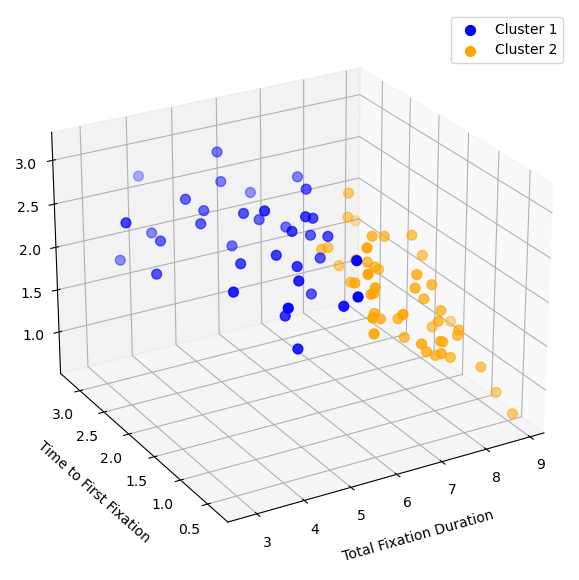

In [72]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# File path to the dataset
file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"

def load_data(file_path):
    """Loads data from a CSV file."""
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully. Shape: {data.shape}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def prepare_data_no_log(data, total_fixation_duration_col, time_to_first_fixation_col, participant_col):
    """Prepares data by computing Fixation Variability Index (FVI) without log transformation."""
    try:
        data['Total Fixation Duration'] = data[total_fixation_duration_col]
        data['Time to First Fixation'] = data[time_to_first_fixation_col]

        # Calculate standard deviations for TFD and TTFF per participant
        stds = []
        participants = data[participant_col].unique()
        for participant in participants:
            subset = data[data[participant_col] == participant]
            tfd_std = subset['Total Fixation Duration'].std()
            ttff_std = subset['Time to First Fixation'].std()

            # Weighted equally
            fvi = 0.5 * tfd_std + 0.5 * ttff_std
            stds.append((participant, fvi))

        std_df = pd.DataFrame(stds, columns=[participant_col, 'Fixation Variability Index'])

        # Aggregate TFD and TTFF by mean
        agg_df = data.groupby(participant_col)[
            ['Total Fixation Duration', 'Time to First Fixation']
        ].mean().reset_index()

        # Merge FVI
        agg_df = agg_df.merge(std_df, on=participant_col, how='left')
        return agg_df

    except Exception as e:
        print(f"Error preparing data: {e}")
        return None

# Main execution
data = load_data(file_path)
if data is not None:
    prepared_data = prepare_data_no_log(
        data,
        total_fixation_duration_col='TFD',
        time_to_first_fixation_col='TTFF',
        participant_col='Patient'
    )

    if prepared_data is not None:
        cols_for_clustering = ['Total Fixation Duration', 'Time to First Fixation', 'Fixation Variability Index']

        # Drop NaN rows
        data_clustering = prepared_data.dropna(subset=cols_for_clustering)

        # K-means with 2 clusters
        kmeans = KMeans(n_clusters=2, random_state=42)
        clusters = kmeans.fit_predict(data_clustering[cols_for_clustering])

        # Swap cluster labels (0 → 1, 1 → 2)
        swapped_clusters = np.where(clusters == 0, 1, 2)
        data_clustering['Cluster'] = swapped_clusters

        # Print cluster counts
        print("Number of participants in each cluster after label swap:")
        print(data_clustering['Cluster'].value_counts())

        # 3D Visualization
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_axes([0.15, 0.15, 0.7, 0.7], projection='3d')

        ax.set_xlabel('Total Fixation Duration', labelpad=10)
        ax.set_ylabel('Time to First Fixation', labelpad=10)
        ax.set_zlabel('Fixation Variability Index', labelpad=10)

        # Plot each cluster with different colors
        colors = {1: 'blue', 2: 'orange'}
        for c_label in [1, 2]:
            subset = data_clustering[data_clustering['Cluster'] == c_label]
            ax.scatter(
                subset['Total Fixation Duration'],
                subset['Time to First Fixation'],
                subset['Fixation Variability Index'],
                color=colors[c_label],
                s=50,
                label=f'Cluster {c_label}'
            )

        # **Adjusted Viewing Angle**: Elevation 25 and Azimuth 240 for a bit more rotation.
        ax.view_init(elev=25, azim=240)

        ax.legend()

        # Save the updated figure
        plt.savefig("3D_clusters_more_rotation.png", dpi=300)
        plt.show()


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_26552\690899128.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for th

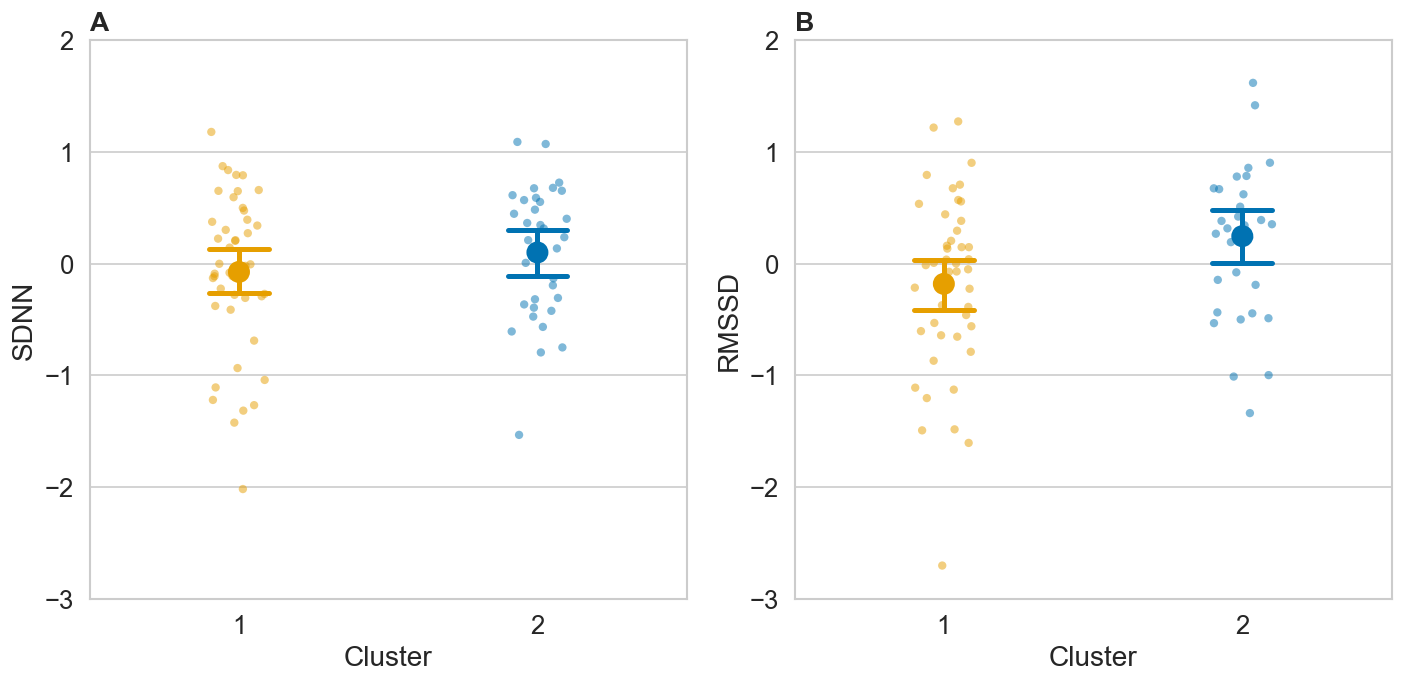

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
y_limits = (-3, 2)

# צבעים תואמים
palette = {8: "#E69F00", 9: "#0072B2"}  # כתום, כחול

# A – SDNN
sns.stripplot(data=clustering_data_gc, x='Cluster', y='HRV_SDNN_residual',
              jitter=True, alpha=0.5, palette=palette, hue='Cluster',
              dodge=False, ax=axes[0])
sns.pointplot(data=clustering_data_gc, x='Cluster', y='HRV_SDNN_residual',
              ci=95, join=False, capsize=0.2, palette=palette, ax=axes[0],
              errwidth=3, scale=1.5)  # קו עבה יותר ונקודה מודגשת
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("SDNN")
axes[0].set_title("A", loc='left', fontsize=16, fontweight='bold')
axes[0].set_ylim(y_limits)
axes[0].set_xticklabels(["1", "2"])
axes[0].legend([], [], frameon=False)

# B – RMSSD
sns.stripplot(data=clustering_data_gc, x='Cluster', y='HRV_RMSSD_residual',
              jitter=True, alpha=0.5, palette=palette, hue='Cluster',
              dodge=False, ax=axes[1])
sns.pointplot(data=clustering_data_gc, x='Cluster', y='HRV_RMSSD_residual',
              ci=95, join=False, capsize=0.2, palette=palette, ax=axes[1],
              errwidth=3, scale=1.5)
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("RMSSD")
axes[1].set_title("B", loc='left', fontsize=16, fontweight='bold')
axes[1].set_ylim(y_limits)
axes[1].set_xticklabels(["1", "2"])
axes[1].legend([], [], frameon=False)

plt.tight_layout()
plt.show()


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\LAB-Mobile\AppData\Local\Temp\ipykernel_26552\1026822270.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for t

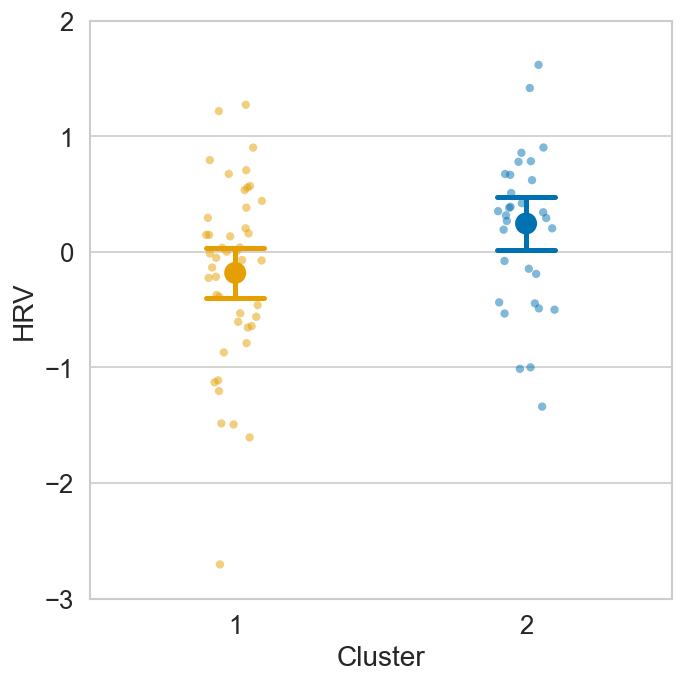

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set color palette for clusters: orange for 8, blue for 9
palette = {8: "#E69F00", 9: "#0072B2"}

# Create a single panel figure
fig, ax = plt.subplots(figsize=(6, 6))
y_limits = (-3, 2)

# Stripplot for RMSSD residuals
sns.stripplot(data=clustering_data_gc, x='Cluster', y='HRV_RMSSD_residual',
              jitter=True, alpha=0.5, palette=palette, hue='Cluster',
              dodge=False, ax=ax)

# Pointplot with confidence intervals
sns.pointplot(data=clustering_data_gc, x='Cluster', y='HRV_RMSSD_residual',
              ci=95, join=False, capsize=0.2, palette=palette, ax=ax,
              errwidth=3, scale=1.5)

# Set labels and axis limits
ax.set_xlabel("Cluster")
ax.set_ylabel("HRV")
ax.set_ylim(y_limits)
ax.set_xticklabels(["1", "2"])

# Remove legend
ax.legend([], [], frameon=False)

# Adjust layout
plt.tight_layout()
plt.show()


In [165]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy.stats import ttest_ind

# File paths
clustering_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"
clinical_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\clinical data.csv"
baseline_file_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\Baseline_data.csv"

# Load datasets
clustering_data = pd.read_csv(clustering_file_path)
clinical_data = pd.read_csv(clinical_file_path)

# Define physiological features
physiological_features = ['GSR Mean[%]', 'HR[%]', 'HRV_SDNN[%]', 'HRV_RMSSD[%]', 
                          'Respiration Rate[%]', 'Respiration Depth[%]']

# Variable for age in clinical data
age_col = 'crf_tes_age'

# Convert physiological features and age to numeric
clustering_data[physiological_features] = clustering_data[physiological_features].apply(pd.to_numeric, errors='coerce')
clinical_data[age_col] = pd.to_numeric(clinical_data[age_col], errors='coerce')

# Format Patient IDs in clustering data to match AP### format
clustering_data['Patient'] = clustering_data['Patient'].apply(lambda x: f"AP{int(x):03}")

# Apply MAD filtering to physiological features
def apply_mad_filtering_participant(data, columns, participant_col, threshold=3):
    for col in columns:
        if col in data:
            participants = data[participant_col].unique()
            for participant in participants:
                subset = data[data[participant_col] == participant][col].dropna()
                if not subset.empty:
                    median = subset.median()
                    mad = np.median(np.abs(subset - median))
                    mad_threshold = mad * threshold if mad > 0 else 0
                    data.loc[data[participant_col] == participant, col] = np.where(
                        np.abs(data.loc[data[participant_col] == participant, col] - median) > mad_threshold,
                        np.nan,
                        data.loc[data[participant_col] == participant, col]
                    )
    return data

clustering_data = apply_mad_filtering_participant(clustering_data, physiological_features, participant_col='Patient')

# Prepare data for clustering
data_clustering = clustering_data.dropna(subset=['TFD', 'TTFF']).copy()

def prepare_general_std_data(data, tfd_col, ttff_col, participant_col):
    stds = []
    participants = data[participant_col].unique()
    for participant in participants:
        subset = data[data[participant_col] == participant]
        tfd_std = subset[tfd_col].std()
        ttff_std = subset[ttff_col].std()
        general_std = 0.5 * tfd_std + 0.5 * ttff_std
        stds.append((participant, general_std))

    std_data = pd.DataFrame(stds, columns=[participant_col, 'General_Std'])
    aggregated_data = data.groupby(participant_col)[[tfd_col, ttff_col]].mean().reset_index()
    aggregated_data = aggregated_data.merge(std_data, on=participant_col)
    return aggregated_data

data_prepared = prepare_general_std_data(data_clustering, tfd_col='TFD', ttff_col='TTFF', participant_col='Patient')

# Drop rows with missing clustering data
data_prepared = data_prepared.dropna()

# Scale clustering data
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_prepared[['TFD', 'TTFF', 'General_Std']]),
                           columns=['TFD', 'TTFF', 'General_Std'], index=data_prepared['Patient'])

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
data_prepared['Cluster'] = kmeans.fit_predict(data_scaled)

# Map cluster labels back to the original data
clustering_data['Cluster'] = clustering_data['Patient'].map(data_prepared.set_index('Patient')['Cluster'])

# Ensure 'Condition' is sourced from clustering_data
if 'Condition' not in clustering_data.columns:
    print("Error: 'Condition' column not found in clustering_data. Available columns:", clustering_data.columns)
    raise KeyError("'Condition' column missing in clustering_data")

# Merge age information from clinical data into clustering data
clustering_data = pd.merge(
    clustering_data,
    clinical_data[['patient', age_col]].rename(columns={'patient': 'Patient'}),
    on='Patient',
    how='left'
)

# Sanitize column names
clustering_data.rename(columns=lambda x: x.replace('[', '').replace(']', '').replace('%', '').replace(' ', '_'), inplace=True)

# Adjust the physiological features list
physiological_features = ['GSR_Mean', 'HR', 'HRV_SDNN', 'HRV_RMSSD', 'Respiration_Rate', 'Respiration_Depth']


# Step 3: Baseline Analysis
print("\n=== Baseline Physiological Comparison by Cluster ===")
baseline_data = pd.read_csv(baseline_file_path)
baseline_data['patient'] = baseline_data['patient'].apply(lambda x: f"AP{int(x):03}")
baseline_data.rename(columns={'patient': 'Patient'}, inplace=True)
baseline_data.rename(columns=lambda x: x.strip().replace(' ', '_'), inplace=True)

# Join with cluster labels
baseline_merged = pd.merge(
    baseline_data,
    clustering_data[['Patient', 'Cluster']].drop_duplicates(),
    on='Patient',
    how='left'
)

# Define baseline physiological features
baseline_features = ['GSR_Mean', 'HR', 'HRV_SDNN', 'HRV_RMSSD', 'Respiration_Rate', 'Respiration_Depth']

# T-test and descriptives
for feature in baseline_features:
    cluster0 = baseline_merged[baseline_merged['Cluster'] == 0][feature].dropna()
    cluster1 = baseline_merged[baseline_merged['Cluster'] == 1][feature].dropna()

    mean0, std0, n0 = cluster0.mean(), cluster0.std(), cluster0.shape[0]
    mean1, std1, n1 = cluster1.mean(), cluster1.std(), cluster1.shape[0]

    t_stat, p_val = ttest_ind(cluster0, cluster1, equal_var=False)

    print(f"\n{feature}:")
    print(f"  Cluster 0 - Mean: {mean0:.2f}, SD: {std0:.2f}, n = {n0}")
    print(f"  Cluster 1 - Mean: {mean1:.2f}, SD: {std1:.2f}, n = {n1}")
    print(f"  T-test: t = {t_stat:.2f}, p = {p_val:.4f}")

# Step 4: Reactivity (Δ) Analysis
print("\n=== Reactivity (Δ) Physiological Comparison by Cluster ===")

# Load the measurements data
reactivity_data_path = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\measurements.csv"
reactivity_data = pd.read_csv(reactivity_data_path)

# Format Patient IDs
reactivity_data['patient'] = reactivity_data['patient'].apply(lambda x: f"AP{int(x):03}")
reactivity_data.rename(columns={'patient': 'Patient'}, inplace=True)
reactivity_data.rename(columns=lambda x: x.strip().replace('.', '_'), inplace=True)

# Merge cluster labels
reactivity_merged = pd.merge(
    reactivity_data,
    clustering_data[['Patient', 'Cluster']].drop_duplicates(),
    on='Patient',
    how='left'
)

# Define physiological Δ features (same as baseline, but from reactivity)
reactivity_features = ['GSR_Mean', 'HR', 'HRV_SDNN', 'HRV_RMSSD', 'Respiration_Rate', 'Respiration_Depth']

# T-test and descriptives for reactivity
for feature in reactivity_features:
    cluster0 = reactivity_merged[reactivity_merged['Cluster'] == 0][feature].dropna()
    cluster1 = reactivity_merged[reactivity_merged['Cluster'] == 1][feature].dropna()

    mean0, std0, n0 = cluster0.mean(), cluster0.std(), cluster0.shape[0]
    mean1, std1, n1 = cluster1.mean(), cluster1.std(), cluster1.shape[0]

    t_stat, p_val = ttest_ind(cluster0, cluster1, equal_var=False)

    print(f"\n{feature} (Δ):")
    print(f"  Cluster 0 - Mean: {mean0:.2f}, SD: {std0:.2f}, n = {n0}")
    print(f"  Cluster 1 - Mean: {mean1:.2f}, SD: {std1:.2f}, n = {n1}")
    print(f"  T-test: t = {t_stat:.2f}, p = {p_val:.4f}")
    
    print("\n=== Linear Mixed Models (LMM) on Reactivity Measures ===")


print("\n=== Final LMM on Baseline HRV (All Conditions, No Age) ===")

# HRV only
hrv_features = ['HRV_SDNN', 'HRV_RMSSD']

for feature in hrv_features:
    data = baseline_merged[['Patient', 'Cluster', feature]].dropna()

    if data['Cluster'].nunique() < 2:
        print(f"Skipping {feature} - only one cluster present")
        continue

    try:
        model = mixedlm(f"{feature} ~ Cluster", data, groups=data['Patient'])
        result = model.fit()
        print(f"\n{feature} (Baseline) - LMM Summary:")
        print(result.summary())
    except Exception as e:
        print(f"Error in model for {feature}: {e}")


import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

# NEW PART: Apply MAD filtering on baseline data (not mixed)
def mad_filter_baseline(data, columns, participant_col='Patient', trial_col='Trial', threshold=3):
    excluded = set()
    for col in columns:
        if col in data:
            for participant in data[participant_col].unique():
                subset = data[data[participant_col] == participant][col].dropna()
                if not subset.empty:
                    median = subset.median()
                    mad = np.median(np.abs(subset - median))
                    mad_threshold = mad * threshold if mad > 0 else 0
                    mask = (
                        (data[participant_col] == participant) &
                        (np.abs(data[col] - median) > mad_threshold)
                    )
                    excluded.update(zip(data.loc[mask, participant_col], data.loc[mask, trial_col]))
                    data.loc[mask, col] = np.nan
    return data, excluded

# Load and prepare baseline data
baseline_data = pd.read_csv(baseline_file_path)
baseline_data['patient'] = baseline_data['patient'].apply(lambda x: f"AP{int(x):03}")
baseline_data.rename(columns={'patient': 'Patient'}, inplace=True)
baseline_data.rename(columns=lambda x: x.strip().replace(' ', '_'), inplace=True)

# Define features
baseline_features = ['GSR_Mean', 'HR', 'HRV_SDNN', 'HRV_RMSSD', 'Respiration_Rate', 'Respiration_Depth']

# Apply MAD filtering on baseline data
baseline_data, excluded_trials = mad_filter_baseline(
    baseline_data, baseline_features, participant_col='Patient', trial_col='Trial', threshold=3
)

# Apply log transform before LMM
for feature in ['HRV_SDNN', 'HRV_RMSSD']:
    baseline_data[feature] = np.log1p(baseline_data[feature])

# Merge cluster labels into baseline data again after filtering
baseline_merged = pd.merge(
    baseline_data,
    clustering_data[['Patient', 'Cluster']].drop_duplicates(),
    on='Patient',
    how='left'
)

# Now you can continue with LMM as before:
print("\n=== Final LMM on Baseline HRV (log-transformed, MAD on baseline) ===")

for feature in ['HRV_SDNN', 'HRV_RMSSD']:
    data = baseline_merged[['Patient', 'Cluster', feature]].dropna()

    if data['Cluster'].nunique() < 2:
        print(f"Skipping {feature} - only one cluster present")
        continue

    try:
        model = mixedlm(f"{feature} ~ Cluster", data, groups=data['Patient'])
        result = model.fit()
        print(f"\n{feature} (Baseline, log) - LMM Summary:")
        print(result.summary())
    except Exception as e:
        print(f"Error in model for {feature}: {e}")



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



=== Baseline Physiological Comparison by Cluster ===

GSR_Mean:
  Cluster 0 - Mean: 0.00, SD: 0.01, n = 1090
  Cluster 1 - Mean: 0.00, SD: 0.01, n = 645
  T-test: t = 1.39, p = 0.1648

HR:
  Cluster 0 - Mean: 68.39, SD: 12.06, n = 1212
  Cluster 1 - Mean: 63.39, SD: 10.91, n = 804
  T-test: t = 9.66, p = 0.0000

HRV_SDNN:
  Cluster 0 - Mean: 30.69, SD: 42.47, n = 1211
  Cluster 1 - Mean: 27.41, SD: 43.03, n = 804
  T-test: t = 1.68, p = 0.0927

HRV_RMSSD:
  Cluster 0 - Mean: 31.49, SD: 43.63, n = 1207
  Cluster 1 - Mean: 27.94, SD: 40.84, n = 804
  T-test: t = 1.86, p = 0.0628

Respiration_Rate:
  Cluster 0 - Mean: 16.68, SD: 4.12, n = 1250
  Cluster 1 - Mean: 17.50, SD: 3.42, n = 820
  T-test: t = -4.94, p = 0.0000

Respiration_Depth:
  Cluster 0 - Mean: 12.99, SD: 7.89, n = 1253
  Cluster 1 - Mean: 11.50, SD: 6.95, n = 822
  T-test: t = 4.54, p = 0.0000

=== Reactivity (Δ) Physiological Comparison by Cluster ===

GSR_Mean (Δ):
  Cluster 0 - Mean: 4.98, SD: 0.88, n = 1087
  Cluster 1

In [87]:
# === Paths (raw strings) ===
VR_PATH   = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\VR_data_mixed.csv"
CLIN_XLSX = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\clinical data.xlsx"
CLIN_CSV  = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\clinical data.csv"
OUT_CSV   = r"C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\summary_dataset.csv"

# ---- Helpers ----
AP_RE = re.compile(r"^AP\d{3}$", re.IGNORECASE)

def to_ap(x):
    s = str(x).strip().upper()
    if AP_RE.match(s):
        return s
    digits = "".join(ch for ch in s if ch.isdigit())
    return f"AP{int(digits):03d}" if digits else s

def find_id_col(df):
    # common names first
    for cand in ["Patient", "patient", "crf_record_id", "record_id", "ID", "id"]:
        if cand in df.columns:
            return cand
    # else look for a column that looks like AP###
    for col in df.columns:
        vals = df[col].dropna().astype(str).str.strip().str.upper()
        if not vals.empty and (vals.map(lambda v: bool(AP_RE.match(v))).mean() > 0.6):
            return col
    raise ValueError("Could not find an ID column with values like 'AP001'.")

# ---- Load VR (gaze + physiology) ----
vr = pd.read_csv(VR_PATH)

vr_id_col = find_id_col(vr)
vr = vr.rename(columns={vr_id_col: "Patient"})
vr["Patient"] = vr["Patient"].map(to_ap)

# Gaze & Phys columns (from your files)
gaze_cols = ["TTFF", "TFD"]
phys_cols = [
    "GSR Mean[%]",
    "HR[%]",
    "HRV_SDNN[%]",
    "HRV_RMSSD[%]",
    "Respiration Rate[%]",
    "Respiration Depth[%]",
]
use_cols = [c for c in gaze_cols + phys_cols if c in vr.columns]
if not set(gaze_cols).issubset(vr.columns):
    raise ValueError("VR_data_mixed.csv must include both 'TTFF' and 'TFD' columns.")

# Force numeric (handles commas as decimals, blanks)
vr[use_cols] = vr[use_cols].replace({",": "."}, regex=True).apply(pd.to_numeric, errors="coerce")

# Per-participant MEANS only
vr_means = vr.groupby("Patient", as_index=False)[use_cols].mean()

# ---- Load Clinical (ONLY from clinical data file) ----
if os.path.exists(CLIN_XLSX):
    clin = pd.read_excel(CLIN_XLSX)
elif os.path.exists(CLIN_CSV):
    clin = pd.read_csv(CLIN_CSV)
else:
    raise FileNotFoundError("Clinical data file not found (xlsx/csv).")

clin_id_col = find_id_col(clin)
clin = clin.rename(columns={clin_id_col: "Patient"})
clin["Patient"] = clin["Patient"].map(to_ap)

# Keep totals only (no domains)
keep = ["Patient"]
for name in ["crf_tes_age", "MOCA_1", "MOCA_Total", "LARS", "LARS_Total", "gds_total", "GDS_Total"]:
    if name in clin.columns:
        keep.append(name)
clin = clin[keep].copy()

# Coerce numerics & normalize names
for c in ["crf_tes_age", "MOCA_1", "MOCA_Total", "LARS", "LARS_Total", "gds_total", "GDS_Total"]:
    if c in clin.columns:
        clin[c] = pd.to_numeric(clin[c], errors="coerce")

if "MOCA_Total" not in clin.columns and "MOCA_1" in clin.columns:
    clin = clin.rename(columns={"MOCA_1": "MOCA_Total"})
if "LARS_Total" not in clin.columns and "LARS" in clin.columns:
    clin = clin.rename(columns={"LARS": "LARS_Total"})
if "GDS_Total" not in clin.columns and "gds_total" in clin.columns:
    clin = clin.rename(columns={"gds_total": "GDS_Total"})

# ---- Merge & Save ----
summary = vr_means.merge(clin, on="Patient", how="left")
summary.to_csv(OUT_CSV, index=False, encoding="utf-8")

print(f"Saved SUMMARY: {OUT_CSV}")
print(f"N participants: {summary.shape[0]}, N columns: {summary.shape[1]}")
print("Columns:", list(summary.columns))


Saved SUMMARY: C:\Users\LAB-Mobile\Documents\Daniel\Research\Var Apathy Project\summary_dataset.csv
N participants: 96, N columns: 13
Columns: ['Patient', 'TTFF', 'TFD', 'GSR Mean[%]', 'HR[%]', 'HRV_SDNN[%]', 'HRV_RMSSD[%]', 'Respiration Rate[%]', 'Respiration Depth[%]', 'crf_tes_age', 'MOCA_Total', 'LARS_Total', 'GDS_Total']
